# Phase 2: 판매자 조기 경보 시스템

## 목표
**"지난달(t)의 판매자 데이터를 바탕으로, 이번 달(t+1)에 해당 판매자가 사고를 칠지(Target) 예측"**

## Phase 1 vs Phase 2

| 구분 | Phase 1 (현재) | Phase 2 (예측) |
|------|----------------|----------------|
| 방식 | 규칙 기반 분류 | 시계열 예측 |
| 시점 | 사후 진단 | **사전 예방** |
| Input | 전체 기간 집계 | 지난달 데이터 |
| Output | 현재 위험 판매자 | **다음 달 위험 판매자** |


In [2173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('Olist_DataSet/ML_olist.csv')

In [2174]:
# 필요한 컬럼만 선택
cols_needed = [
    'order_id', 'seller_id', 'order_purchase_timestamp',
    'review_score', 'has_text_review',
    'seller_delay_days', 'seller_processing_days',
    'processing_days_diff',
    'is_logistics_fault'
]

df = df[cols_needed].copy()

# 날짜 변환
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# 월(Year-Month) 추출
df['year_month'] = df['order_purchase_timestamp'].dt.to_period('M')

# 물류사 과실 제외 (Phase 1과 동일)
df = df[df['is_logistics_fault'] == False].copy()

print("=" * 80)
print("데이터 로드 완료 (물류사 과실 제외)")
print("=" * 80)
print(f"행 수: {len(df):,}")
print(f"판매자 수: {df['seller_id'].nunique():,}명")


데이터 로드 완료 (물류사 과실 제외)
행 수: 62,386
판매자 수: 2,635명


---
## Step 1. 파생 변수 생성


In [2175]:
# 1.1 is_Seller_of_Note 계산에 필요한 이진 변수 생성

# (1) 처리 지연 여부: processing_days_diff > 0
df['is_processing_delayed'] = (df['processing_days_diff'] > 0).astype(int)

# (2) 출고 지연 여부: seller_delay_days > 0
df['is_seller_delayed'] = (df['seller_delay_days'] > 0).astype(int)

# (3) 불만족 리뷰 여부: review_score <= 3
df['is_negative_review'] = (df['review_score'] <= 3).astype(int)

print("=" * 80)
print("1.1 is_Seller_of_Note 계산용 이진 변수 생성")
print("=" * 80)
print(f"(1) 처리 지연 (processing_days_diff > 0): {df['is_processing_delayed'].sum():,}건 ({df['is_processing_delayed'].mean()*100:.2f}%)")
print(f"(2) 출고 지연 (seller_delay_days > 0): {df['is_seller_delayed'].sum():,}건 ({df['is_seller_delayed'].mean()*100:.2f}%)")
print(f"(3) 불만족 리뷰 (review_score <= 3): {df['is_negative_review'].sum():,}건 ({df['is_negative_review'].mean()*100:.2f}%)")


1.1 is_Seller_of_Note 계산용 이진 변수 생성
(1) 처리 지연 (processing_days_diff > 0): 21,030건 (33.71%)
(2) 출고 지연 (seller_delay_days > 0): 4,485건 (7.19%)
(3) 불만족 리뷰 (review_score <= 3): 11,703건 (18.76%)


In [2176]:
# 1.2 추가 파생변수 (피처로 사용)

# 심각한 불만: 평점 3점 이하 + 텍스트 리뷰 작성
df['is_critical_complaint'] = (
    (df['review_score'] <= 3) & (df['has_text_review'] == True)
).astype(int)

print("=" * 80)
print("1.2 추가 파생변수 생성")
print("=" * 80)
print(f"심각한 불만 (review<=3 AND 텍스트 리뷰): {df['is_critical_complaint'].sum():,}건 ({df['is_critical_complaint'].mean()*100:.2f}%)")


1.2 추가 파생변수 생성
심각한 불만 (review<=3 AND 텍스트 리뷰): 7,780건 (12.47%)


---
## Step 2. 시계열 집계 

판매자별 + 월별로 데이터를 집계합니다.

### 집계 지표
| 원본 변수 | 집계 방식 | 의미 |
|-----------|-----------|------|
| `is_processing_delayed` | mean | **처리 지연율** (is_Seller_of_Note 조건 1) |
| `is_seller_delayed` | mean | **출고 지연율** (is_Seller_of_Note 조건 2) |
| `is_negative_review` | mean | **불만족 리뷰율** (is_Seller_of_Note 조건 3) |
| `is_critical_complaint` | mean | 심각한 불만율 (피처용) |
| `seller_processing_days` | mean, std | 처리 속도 및 일관성 (피처용) |
| `order_id` | count | 판매 규모 |


In [2177]:
# 월별 판매자 집계

monthly_stats = df.groupby(['seller_id', 'year_month']).agg({
    # is_Seller_of_Note 계산용 
    'is_processing_delayed': 'mean',   
    'is_seller_delayed': 'mean',       
    'is_negative_review': 'mean',      
    
    # 피처용
    'is_critical_complaint': 'mean',   # 심각한 불만율
    'seller_processing_days': ['mean', 'std'],  # 처리 시간 평균/편차
    'order_id': 'count',               # 주문 건수
}).reset_index()

# 컬럼명 정리 
monthly_stats.columns = [
    'seller_id', 'year_month',
    'processing_delay_rate',   
    'seller_delay_rate',        
    'negative_review_rate',     
    'critical_complaint_rate',  
    'processing_days_mean', 'processing_days_std',
    'order_count'
]

# std의 NaN 처리 (주문 1건인 경우 std가 NaN)
monthly_stats['processing_days_std'] = monthly_stats['processing_days_std'].fillna(0)

In [2178]:
# 집계 결과 샘플 확인
print("집계 결과 샘플 (상위 10행)")
monthly_stats.head(10)


집계 결과 샘플 (상위 10행)


,seller_id,year_month,processing_delay_rate,seller_delay_rate,negative_review_rate,critical_complaint_rate,processing_days_mean,processing_days_std,order_count
0,001cca7ae9ae17fb1caed9dfb1094831,2017-02,0.000000,0.0,0.000000,0.000000,0.950000,0.000000,1
1,001cca7ae9ae17fb1caed9dfb1094831,2017-03,0.846154,0.0,0.461538,0.307692,3.943077,1.563023,13
2,001cca7ae9ae17fb1caed9dfb1094831,2017-04,0.090909,0.0,0.363636,0.272727,1.021818,1.019949,11
3,001cca7ae9ae17fb1caed9dfb1094831,2017-05,0.000000,0.0,0.318182,0.227273,0.846818,0.529028,22
4,001cca7ae9ae17fb1caed9dfb1094831,2017-06,0.476190,0.0,0.142857,0.047619,2.187619,1.323548,21
5,001cca7ae9ae17fb1caed9dfb1094831,2017-07,0.071429,0.0,0.214286,0.214286,1.311429,0.820749,14
6,001cca7ae9ae17fb1caed9dfb1094831,2017-08,0.272727,0.0,0.272727,0.181818,1.528182,0.922657,11
7,001cca7ae9ae17fb1caed9dfb1094831,2017-09,0.454545,0.0,0.181818,0.090909,2.730909,1.167677,11
8,001cca7ae9ae17fb1caed9dfb1094831,2018-01,0.400000,0.2,0.000000,0.000000,2.486000,1.247670,5
9,001cca7ae9ae17fb1caed9dfb1094831,2018-02,0.500000,0.5,0.500000,0.500000,3.990000,2.856711,2


In [2179]:
# 집계 통계 확인
print("집계 변수 통계")
monthly_stats.describe().round(3)


집계 변수 통계


,processing_delay_rate,seller_delay_rate,negative_review_rate,critical_complaint_rate,processing_days_mean,processing_days_std,order_count
count,11594.000,11594.000,11594.000,11594.000,11594.000,11594.000,11594.000
mean,0.345,0.081,0.168,0.109,2.575,0.821,5.381
std,0.396,0.230,0.284,0.237,2.564,1.190,10.288
min,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,0.000,0.000,0.000,0.000,1.055,0.000,1.000
50%,0.167,0.000,0.000,0.000,1.808,0.459,2.000
75%,0.667,0.000,0.250,0.100,3.160,1.240,5.000
max,1.000,1.000,1.000,1.000,40.620,19.778,200.000


---
## Step 2.5. 월별 is_Seller_of_Note 계산

### Phase 1 정의 (전체 기간 기준)
- 판매량 상위 25%: 75% 분위수 (엄격한 기준)
- 판매량 중간 26-50%: 90% 분위수 (유연한 기준)

### Phase 2 적용 (월별 기준)
- **매월 판매량 분위수를 계산하여 그룹 분류**
- 그룹별 차등 기준 적용 (Phase 1과 동일 방식)
- 3가지 조건 모두 충족 시 `is_Seller_of_Note = True`


In [2180]:
# 2.5.1 월별 판매량 분위수 계산 및 그룹 분류

def assign_sales_group(monthly_df):
    """
    월별로 판매량 분위수를 계산하여 그룹 분류
    - 상위 25%: 'top25'
    - 중간 26-50%: 'mid'
    - 하위 50%: 'bottom' (분석 제외)
    """
    result = monthly_df.copy()
    result['sales_group'] = 'bottom'  # 기본값
    
    for ym in result['year_month'].unique():
        mask = result['year_month'] == ym
        orders = result.loc[mask, 'order_count']
        
        # 해당 월의 분위수 계산
        q50 = orders.quantile(0.50)
        q75 = orders.quantile(0.75)
        
        # 그룹 할당
        result.loc[mask & (orders > q75), 'sales_group'] = 'top25'
        result.loc[mask & (orders > q50) & (orders <= q75), 'sales_group'] = 'mid'
    
    return result

monthly_stats = assign_sales_group(monthly_stats)

print("=" * 80)
print("월별 판매량 그룹 분류 완료")
print("=" * 80)
print(f"\n그룹별 분포:")
print(monthly_stats['sales_group'].value_counts())


월별 판매량 그룹 분류 완료

그룹별 분포:
sales_group
bottom    6571
top25     2604
mid       2419
Name: count, dtype: int64


In [2181]:
# 2.5.2 그룹별 차등 기준으로 is_Seller_of_Note 계산

def calculate_monthly_seller_of_note(monthly_df):
    """
    월별로 그룹별 차등 기준을 적용하여 is_Seller_of_Note 계산
    - 상위 25%: 75% 분위수 기준 (엄격)
    - 중간 26-50%: 90% 분위수 기준 (유연)
    - 하위 50%: 분석 제외 (항상 False)
    """
    result = monthly_df.copy()
    result['is_Seller_of_Note'] = False
    
    for ym in result['year_month'].unique():
        ym_mask = result['year_month'] == ym
        
        # --- 상위 25% 그룹 (엄격한 기준: 모든 지표 75% 분위수) ---
        top25_mask = ym_mask & (result['sales_group'] == 'top25')
        if top25_mask.sum() > 0:
            top25_data = result.loc[top25_mask]
            
            thresh_proc = top25_data['processing_delay_rate'].quantile(0.75)
            thresh_sell = top25_data['seller_delay_rate'].quantile(0.75)
            thresh_neg = top25_data['negative_review_rate'].quantile(0.75)  # 일관성 있게 0.75
            
            is_note_top25 = (
                (result['processing_delay_rate'] >= thresh_proc) &
                (result['seller_delay_rate'] >= thresh_sell) &
                (result['negative_review_rate'] >= thresh_neg)
            )
            result.loc[top25_mask & is_note_top25, 'is_Seller_of_Note'] = True
        
        # --- 중간 26-50% 그룹 (유연한 기준: 90% 분위수) ---
        mid_mask = ym_mask & (result['sales_group'] == 'mid')
        if mid_mask.sum() > 0:
            mid_data = result.loc[mid_mask]
            
            thresh_proc = mid_data['processing_delay_rate'].quantile(0.90)
            thresh_sell = mid_data['seller_delay_rate'].quantile(0.90)
            thresh_neg = mid_data['negative_review_rate'].quantile(0.90)
            
            is_note_mid = (
                (result['processing_delay_rate'] >= thresh_proc) &
                (result['seller_delay_rate'] >= thresh_sell) &
                (result['negative_review_rate'] >= thresh_neg)
            )
            result.loc[mid_mask & is_note_mid, 'is_Seller_of_Note'] = True
    
    return result

monthly_stats = calculate_monthly_seller_of_note(monthly_stats)

print("=" * 80)
print("월별 is_Seller_of_Note 계산 완료")
print("=" * 80)
print(f"\nis_Seller_of_Note 분포:")
print(monthly_stats['is_Seller_of_Note'].value_counts())
print(f"\n유의 판매자 비율: {monthly_stats['is_Seller_of_Note'].mean()*100:.2f}%")


월별 is_Seller_of_Note 계산 완료

is_Seller_of_Note 분포:
is_Seller_of_Note
False    11405
True       189
Name: count, dtype: int64

유의 판매자 비율: 1.63%


---
## Step 2.6. 유의 판매자가 적게 나오는 이유 분석

### 문제 상황
- 유의 판매자 비율: **1.63%** (189건 / 11,594건)
- 이는 매우 낮은 비율로, 기준이 너무 엄격할 가능성이 있음

### 주요 원인 분석
1. **3가지 조건 모두 AND 조건**: 각 조건이 독립적이라면 모두 충족할 확률이 매우 낮음
2. **분위수 기준이 높음**: 75% 또는 90% 분위수
3. **하위 50% 판매자 제외**: 전체의 절반은 분석 대상에서 제외
4. **월별 기준 적용**: 각 월별로 기준을 계산하므로 샘플 수가 적어 더 엄격해질 수 있음


In [2182]:
# 2.6.1 각 조건별 충족 비율 분석

print("=" * 80)
print("각 조건별 충족 비율 분석 (월별 기준)")
print("=" * 80)

# 월별로 각 조건의 분위수 기준과 충족 비율 계산
condition_analysis = []

for ym in monthly_stats['year_month'].unique():
    ym_mask = monthly_stats['year_month'] == ym
    
    # 상위 25% 그룹
    top25_mask = ym_mask & (monthly_stats['sales_group'] == 'top25')
    if top25_mask.sum() > 0:
        top25_data = monthly_stats.loc[top25_mask]
        
        thresh_proc = top25_data['processing_delay_rate'].quantile(0.75)
        thresh_sell = top25_data['seller_delay_rate'].quantile(0.75)
        thresh_neg = top25_data['negative_review_rate'].quantile(0.75)
        
        # 각 조건별 충족 비율
        cond1 = (top25_data['processing_delay_rate'] >= thresh_proc).mean()
        cond2 = (top25_data['seller_delay_rate'] >= thresh_sell).mean()
        cond3 = (top25_data['negative_review_rate'] >= thresh_neg).mean()
        cond_all = ((top25_data['processing_delay_rate'] >= thresh_proc) &
                    (top25_data['seller_delay_rate'] >= thresh_sell) &
                    (top25_data['negative_review_rate'] >= thresh_neg)).mean()
        
        condition_analysis.append({
            'year_month': ym,
            'group': 'top25',
            'count': top25_mask.sum(),
            'thresh_proc': thresh_proc,
            'thresh_sell': thresh_sell,
            'thresh_neg': thresh_neg,
            'cond1_rate': cond1,
            'cond2_rate': cond2,
            'cond3_rate': cond3,
            'cond_all_rate': cond_all,
            'expected_rate': cond1 * cond2 * cond3  # 독립적이라면 기대 비율
        })
    
    # 중간 26-50% 그룹
    mid_mask = ym_mask & (monthly_stats['sales_group'] == 'mid')
    if mid_mask.sum() > 0:
        mid_data = monthly_stats.loc[mid_mask]
        
        thresh_proc = mid_data['processing_delay_rate'].quantile(0.90)
        thresh_sell = mid_data['seller_delay_rate'].quantile(0.90)
        thresh_neg = mid_data['negative_review_rate'].quantile(0.90)
        
        # 각 조건별 충족 비율
        cond1 = (mid_data['processing_delay_rate'] >= thresh_proc).mean()
        cond2 = (mid_data['seller_delay_rate'] >= thresh_sell).mean()
        cond3 = (mid_data['negative_review_rate'] >= thresh_neg).mean()
        cond_all = ((mid_data['processing_delay_rate'] >= thresh_proc) &
                    (mid_data['seller_delay_rate'] >= thresh_sell) &
                    (mid_data['negative_review_rate'] >= thresh_neg)).mean()
        
        condition_analysis.append({
            'year_month': ym,
            'group': 'mid',
            'count': mid_mask.sum(),
            'thresh_proc': thresh_proc,
            'thresh_sell': thresh_sell,
            'thresh_neg': thresh_neg,
            'cond1_rate': cond1,
            'cond2_rate': cond2,
            'cond3_rate': cond3,
            'cond_all_rate': cond_all,
            'expected_rate': cond1 * cond2 * cond3
        })

condition_df = pd.DataFrame(condition_analysis)

print("\n[그룹별 평균 충족 비율]")
summary = condition_df.groupby('group').agg({
    'cond1_rate': 'mean',
    'cond2_rate': 'mean',
    'cond3_rate': 'mean',
    'cond_all_rate': 'mean',
    'expected_rate': 'mean',
    'count': 'mean'
}).round(4)

print(summary)


각 조건별 충족 비율 분석 (월별 기준)

[그룹별 평균 충족 비율]
       cond1_rate  cond2_rate  cond3_rate  cond_all_rate  expected_rate  \
group                                                                     
mid        0.1342      0.2304      0.1424         0.0149         0.0049   
top25      0.2627      0.2977      0.2628         0.0590         0.0211   

          count  
group            
mid    142.2941  
top25  153.1765  


In [2183]:
# 2.6.3 조건별 상관관계 분석 (독립성 검증)

print("=" * 80)
print("조건별 상관관계 분석 (독립성 검증)")
print("=" * 80)

# 분석 대상: top25와 mid 그룹만
analysis_data = monthly_stats[monthly_stats['sales_group'].isin(['top25', 'mid'])].copy()

# 각 조건을 이진 변수로 변환 (월별 기준으로)
for ym in analysis_data['year_month'].unique():
    ym_mask = analysis_data['year_month'] == ym
    
    # 상위 25% 그룹
    top25_mask = ym_mask & (analysis_data['sales_group'] == 'top25')
    if top25_mask.sum() > 0:
        top25_data = analysis_data.loc[top25_mask]
        thresh_proc = top25_data['processing_delay_rate'].quantile(0.75)
        thresh_sell = top25_data['seller_delay_rate'].quantile(0.75)
        thresh_neg = top25_data['negative_review_rate'].quantile(0.75)
        
        analysis_data.loc[top25_mask, 'meets_cond1'] = (
            analysis_data.loc[top25_mask, 'processing_delay_rate'] >= thresh_proc
        ).astype(int)
        analysis_data.loc[top25_mask, 'meets_cond2'] = (
            analysis_data.loc[top25_mask, 'seller_delay_rate'] >= thresh_sell
        ).astype(int)
        analysis_data.loc[top25_mask, 'meets_cond3'] = (
            analysis_data.loc[top25_mask, 'negative_review_rate'] >= thresh_neg
        ).astype(int)
    
    # 중간 그룹
    mid_mask = ym_mask & (analysis_data['sales_group'] == 'mid')
    if mid_mask.sum() > 0:
        mid_data = analysis_data.loc[mid_mask]
        thresh_proc = mid_data['processing_delay_rate'].quantile(0.90)
        thresh_sell = mid_data['seller_delay_rate'].quantile(0.90)
        thresh_neg = mid_data['negative_review_rate'].quantile(0.90)
        
        analysis_data.loc[mid_mask, 'meets_cond1'] = (
            analysis_data.loc[mid_mask, 'processing_delay_rate'] >= thresh_proc
        ).astype(int)
        analysis_data.loc[mid_mask, 'meets_cond2'] = (
            analysis_data.loc[mid_mask, 'seller_delay_rate'] >= thresh_sell
        ).astype(int)
        analysis_data.loc[mid_mask, 'meets_cond3'] = (
            analysis_data.loc[mid_mask, 'negative_review_rate'] >= thresh_neg
        ).astype(int)

# 상관관계 계산
corr_matrix = analysis_data[['meets_cond1', 'meets_cond2', 'meets_cond3']].corr()

print("\n[조건별 상관관계 행렬]")
print(corr_matrix.round(4))

print("- 현재 상관계수:", corr_matrix.values[corr_matrix.values != 1.0].mean().round(4))


조건별 상관관계 분석 (독립성 검증)

[조건별 상관관계 행렬]
             meets_cond1  meets_cond2  meets_cond3
meets_cond1       1.0000       0.3293       0.1377
meets_cond2       0.3293       1.0000       0.0947
meets_cond3       0.1377       0.0947       1.0000
- 현재 상관계수: 0.1872


---
## Step 2.7. 가중치 기반 점수 시스템 적용

### ML1에서 사용한 방식
1. **Percentile Rank 변환** (0~100점): 각 지표를 순위로 변환
2. **가중치 적용**: 
   - `seller_delay_rate`: 0.50 (가장 중요)
   - `negative_review_rate`: 0.35 (결과 지표)
   - `processing_delay_rate`: 0.15 (상대적으로 낮은 영향력)
3. **종합 리스크 점수** 계산
4. **상위 N%** 를 유의 판매자로 분류

### Phase 2 적용
- 월별로 Percentile Rank 계산
- 월별로 가중치 기반 리스크 점수 계산
- 기존 AND 조건 방식과 비교


In [2184]:
# 2.7.1 Percentile Rank 변환 (월별 기준)


print("=" * 80)
print("Percentile Rank 변환 (월별 기준, 0~100점)")
print("=" * 80)

# 월별로 Percentile Rank 계산
monthly_stats['score_processing'] = monthly_stats.groupby('year_month')['processing_delay_rate'].transform(
    lambda x: x.rank(pct=True) * 100
)
monthly_stats['score_delay'] = monthly_stats.groupby('year_month')['seller_delay_rate'].transform(
    lambda x: x.rank(pct=True) * 100
)
monthly_stats['score_negative'] = monthly_stats.groupby('year_month')['negative_review_rate'].transform(
    lambda x: x.rank(pct=True) * 100
)

print("\n[개별 리스크 점수 샘플]")
print(monthly_stats[['year_month', 'seller_id', 
                     'processing_delay_rate', 'score_processing',
                     'seller_delay_rate', 'score_delay',
                     'negative_review_rate', 'score_negative']].head(10))


Percentile Rank 변환 (월별 기준, 0~100점)

[개별 리스크 점수 샘플]
  year_month                         seller_id  processing_delay_rate  \
0    2017-02  001cca7ae9ae17fb1caed9dfb1094831               0.000000   
1    2017-03  001cca7ae9ae17fb1caed9dfb1094831               0.846154   
2    2017-04  001cca7ae9ae17fb1caed9dfb1094831               0.090909   
3    2017-05  001cca7ae9ae17fb1caed9dfb1094831               0.000000   
4    2017-06  001cca7ae9ae17fb1caed9dfb1094831               0.476190   
5    2017-07  001cca7ae9ae17fb1caed9dfb1094831               0.071429   
6    2017-08  001cca7ae9ae17fb1caed9dfb1094831               0.272727   
7    2017-09  001cca7ae9ae17fb1caed9dfb1094831               0.454545   
8    2018-01  001cca7ae9ae17fb1caed9dfb1094831               0.400000   
9    2018-02  001cca7ae9ae17fb1caed9dfb1094831               0.500000   

   score_processing  seller_delay_rate  score_delay  negative_review_rate  \
0         24.852941                0.0    36.911765              0.0

In [2185]:
# 2.7.2 가중치 기반 종합 리스크 점수 계산

# ML1과 동일한 가중치 사용
# 상관분석 결과 기반: seller_delay_rate가 negative_review_rate와 가장 높은 상관관계
weights = {
    'processing': 0.15,  # 처리 지연 (상대적으로 낮은 영향력)
    'delay': 0.50,        # 출고 지연 (가장 중요)
    'negative': 0.35      # 불만족 리뷰 (결과 지표)
}

# 종합 리스크 점수 계산
monthly_stats['risk_score'] = (
    monthly_stats['score_processing'] * weights['processing'] +
    monthly_stats['score_delay'] * weights['delay'] +
    monthly_stats['score_negative'] * weights['negative']
)

print("=" * 80)
print("가중치 기반 종합 리스크 점수 계산")
print("=" * 80)
print(f"\n가중치: {weights}")
print(f"\n리스크 점수 통계:")
print(monthly_stats['risk_score'].describe().round(2))


가중치 기반 종합 리스크 점수 계산

가중치: {'processing': 0.15, 'delay': 0.5, 'negative': 0.35}

리스크 점수 통계:
count    11594.00
mean        50.07
std         15.71
min         31.24
25%         36.45
50%         45.74
75%         58.65
max         97.37
Name: risk_score, dtype: float64


In [2186]:
# 2.7.3 가중치 기반 is_Seller_of_Note 계산

def calculate_weighted_seller_of_note(monthly_df):
    """
    가중치 기반 리스크 점수로 is_Seller_of_Note 계산
    - 상위 25% 그룹: 리스크 점수 상위 10%
    - 중간 26-50% 그룹: 리스크 점수 상위 10%
    - 하위 50%: 분석 제외 (항상 False)
    """
    result = monthly_df.copy()
    result['is_Seller_of_Note_weighted'] = False
    
    for ym in result['year_month'].unique():
        ym_mask = result['year_month'] == ym
        
        # --- 상위 25% 그룹 ---
        top25_mask = ym_mask & (result['sales_group'] == 'top25')
        if top25_mask.sum() > 0:
            top25_data = result.loc[top25_mask]
            # 리스크 점수 상위 10%
            threshold = top25_data['risk_score'].quantile(0.90)
            result.loc[top25_mask & (result['risk_score'] >= threshold), 'is_Seller_of_Note_weighted'] = True
        
        # --- 중간 26-50% 그룹 ---
        mid_mask = ym_mask & (result['sales_group'] == 'mid')
        if mid_mask.sum() > 0:
            mid_data = result.loc[mid_mask]
            # 리스크 점수 상위 10%
            threshold = mid_data['risk_score'].quantile(0.90)
            result.loc[mid_mask & (result['risk_score'] >= threshold), 'is_Seller_of_Note_weighted'] = True
    
    return result

monthly_stats = calculate_weighted_seller_of_note(monthly_stats)

print("=" * 80)
print("가중치 기반 is_Seller_of_Note 계산 완료")
print("=" * 80)
print(f"\nis_Seller_of_Note_weighted 분포:")
print(monthly_stats['is_Seller_of_Note_weighted'].value_counts())
print(f"\n유의 판매자 비율: {monthly_stats['is_Seller_of_Note_weighted'].mean()*100:.2f}%")


가중치 기반 is_Seller_of_Note 계산 완료

is_Seller_of_Note_weighted 분포:
is_Seller_of_Note_weighted
False    11066
True       528
Name: count, dtype: int64

유의 판매자 비율: 4.55%


---
## Step 3. Lag Feature 생성

- **예측 모델의 Input(X)은 '과거 데이터'여야만 한다.**
- `shift(1)`: 현재 행에 **이전 달** 데이터를 가져옴
- 이렇게 해야 "지난달 데이터로 이번 달을 예측"하는 구조가 됨

```
원본:       1월    2월    3월    4월
shift(1):   NaN    1월    2월    3월   <- 이전 달 데이터
```


In [2187]:
# Lag Feature 생성 (shift(1) = 이전 달)

# 시간순 정렬
monthly_stats = monthly_stats.sort_values(['seller_id', 'year_month']).reset_index(drop=True)

# Lag 피처 대상 컬럼 (is_Seller_of_Note 조건 + 추가 피처)
feature_cols = [
    # is_Seller_of_Note 조건
    'processing_delay_rate',
    'seller_delay_rate',
    'negative_review_rate',
    # 추가 피처
    'critical_complaint_rate',
    'processing_days_mean', 'processing_days_std',
    'order_count'
]

# 판매자별 shift(1) 적용
for col in feature_cols:
    monthly_stats[f'prev_{col}'] = monthly_stats.groupby('seller_id')[col].shift(1)

print("=" * 80)
print("Lag Feature 생성 완료 (shift(1) = 이전 달)")
print("=" * 80)
print(f"생성된 Lag 피처:")
for col in feature_cols:
    print(f"  - prev_{col}")


Lag Feature 생성 완료 (shift(1) = 이전 달)
생성된 Lag 피처:
  - prev_processing_delay_rate
  - prev_seller_delay_rate
  - prev_negative_review_rate
  - prev_critical_complaint_rate
  - prev_processing_days_mean
  - prev_processing_days_std
  - prev_order_count


In [2188]:
# Lag 피처 확인
print("=" * 80)
print("Lag 피처 예시 (특정 판매자의 시계열)")
print("=" * 80)

# 여러 달 데이터가 있는 판매자 찾기
seller_counts = monthly_stats.groupby('seller_id').size()
sample_seller = seller_counts[seller_counts >= 5].index[0]

sample_df = monthly_stats[monthly_stats['seller_id'] == sample_seller][
    ['year_month', 'seller_delay_rate', 'prev_seller_delay_rate', 
     'negative_review_rate', 'prev_negative_review_rate']
].head(6)

print(f"판매자 ID: {sample_seller[:20]}...")
print(sample_df.to_string(index=False))
print("\n-> prev_* 컬럼은 이전 달 데이터가 옮겨온 것")


Lag 피처 예시 (특정 판매자의 시계열)
판매자 ID: 001cca7ae9ae17fb1cae...
year_month  seller_delay_rate  prev_seller_delay_rate  negative_review_rate  prev_negative_review_rate
   2017-02                0.0                     NaN              0.000000                        NaN
   2017-03                0.0                     0.0              0.461538                   0.000000
   2017-04                0.0                     0.0              0.363636                   0.461538
   2017-05                0.0                     0.0              0.318182                   0.363636
   2017-06                0.0                     0.0              0.142857                   0.318182
   2017-07                0.0                     0.0              0.214286                   0.142857

-> prev_* 컬럼은 이전 달 데이터가 옮겨온 것


---
## Step 4. Target 생성

### 핵심 개념
- **예측 모델의 Output(y)은 '미래의 사고 여부'** 
- `shift(-1)`: 현재 행에 **다음 달** 데이터를 가져옴

### Target 정의 (Phase 1과 동일)
**다음 달에 is_Seller_of_Note가 될 조건:**
- 3가지 조건 모두 충족 (AND)
  - processing_delay_rate >= 분위수 기준
  - seller_delay_rate >= 분위수 기준
  - negative_review_rate >= 분위수 기준

```
원본:        1월    2월    3월    4월
shift(-1):   2월    3월    4월    NaN   <- 다음 달 is_Seller_of_Note
```


In [2189]:
# Target 생성 (shift(-1) = 다음 달)

# 다음 달의 is_Seller_of_Note 가져오기
monthly_stats['target_is_seller_of_note'] = monthly_stats.groupby('seller_id')['is_Seller_of_Note'].shift(-1)

print("=" * 80)
print("Target 생성 완료")
print("=" * 80)
print("Target 정의: 다음 달 is_Seller_of_Note (Phase 1 기준과 동일)")
print(f"\nTarget 분포 (NaN 제외):")
target_counts = monthly_stats['target_is_seller_of_note'].value_counts(dropna=True)
print(f"  False (정상): {target_counts.get(False, 0):,}건")
print(f"  True (유의 판매자): {target_counts.get(True, 0):,}건")
valid_mask = monthly_stats['target_is_seller_of_note'].notna()
print(f"  유의 판매자 비율: {monthly_stats.loc[valid_mask, 'target_is_seller_of_note'].mean()*100:.2f}%")


Target 생성 완료
Target 정의: 다음 달 is_Seller_of_Note (Phase 1 기준과 동일)

Target 분포 (NaN 제외):
  False (정상): 8,789건
  True (유의 판매자): 170건
  유의 판매자 비율: 1.90%


In [2190]:
# Target 예시 확인
print("=" * 80)
print("Target 예시 (특정 판매자의 시계열)")
print("=" * 80)

sample_df = monthly_stats[monthly_stats['seller_id'] == sample_seller][
    ['year_month', 'is_Seller_of_Note', 'target_is_seller_of_note', 
     'processing_delay_rate', 'seller_delay_rate', 'negative_review_rate']
].head(6)

print(f"판매자 ID: {sample_seller[:20]}...")
print(sample_df.to_string(index=False))
print("\n-> target_is_seller_of_note는 다음 달 is_Seller_of_Note 여부")


Target 예시 (특정 판매자의 시계열)
판매자 ID: 001cca7ae9ae17fb1cae...
year_month  is_Seller_of_Note target_is_seller_of_note  processing_delay_rate  seller_delay_rate  negative_review_rate
   2017-02              False                    False               0.000000                0.0              0.000000
   2017-03              False                    False               0.846154                0.0              0.461538
   2017-04              False                    False               0.090909                0.0              0.363636
   2017-05              False                    False               0.000000                0.0              0.318182
   2017-06              False                    False               0.476190                0.0              0.142857
   2017-07              False                    False               0.071429                0.0              0.214286

-> target_is_seller_of_note는 다음 달 is_Seller_of_Note 여부


---
## Step 4.5. 가중치 기반 Target 생성

### 목표
- 가중치 기반 `is_Seller_of_Note_weighted`를 Target으로 사용
- 기존 AND 조건 방식과 비교하여 모델 성능 개선 기대

### Target 정의
**다음 달에 is_Seller_of_Note_weighted가 될 조건:**
- 가중치 기반 리스크 점수 상위 10%


In [2191]:
# 4.5.1 가중치 기반 Target 생성 (shift(-1) = 다음 달)

# 다음 달의 is_Seller_of_Note_weighted 가져오기
monthly_stats['target_is_seller_of_note_weighted'] = monthly_stats.groupby('seller_id')['is_Seller_of_Note_weighted'].shift(-1)

print("=" * 80)
print("가중치 기반 Target 생성 완료")
print("=" * 80)
print("Target 정의: 다음 달 is_Seller_of_Note_weighted (가중치 기반)")
print(f"\nTarget 분포 (NaN 제외):")
target_counts_weighted = monthly_stats['target_is_seller_of_note_weighted'].value_counts(dropna=True)
print(f"  False (정상): {target_counts_weighted.get(False, 0):,}건")
print(f"  True (유의 판매자): {target_counts_weighted.get(True, 0):,}건")
valid_mask_weighted = monthly_stats['target_is_seller_of_note_weighted'].notna()
print(f"  유의 판매자 비율: {monthly_stats.loc[valid_mask_weighted, 'target_is_seller_of_note_weighted'].mean()*100:.2f}%")


가중치 기반 Target 생성 완료
Target 정의: 다음 달 is_Seller_of_Note_weighted (가중치 기반)

Target 분포 (NaN 제외):
  False (정상): 8,487건
  True (유의 판매자): 472건
  유의 판매자 비율: 5.27%


In [2192]:
# 4.5.2 두 가지 Target 비교

print("=" * 80)
print("두 가지 Target 비교")
print("=" * 80)

comparison_target = pd.DataFrame({
    'Target': [
        '기존 (AND 조건)',
        '가중치 기반'
    ],
    '유의 판매자 수': [
        monthly_stats['target_is_seller_of_note'].notna().sum() - monthly_stats['target_is_seller_of_note'].isna().sum() + monthly_stats['target_is_seller_of_note'].sum(),
        monthly_stats['target_is_seller_of_note_weighted'].notna().sum() - monthly_stats['target_is_seller_of_note_weighted'].isna().sum() + monthly_stats['target_is_seller_of_note_weighted'].sum()
    ]
})

# NaN 제외한 실제 분포
target_and_valid = monthly_stats['target_is_seller_of_note'].dropna()
target_weighted_valid = monthly_stats['target_is_seller_of_note_weighted'].dropna()

print("\n[Target 분포 비교]")
print(f"기존 (AND 조건):")
print(f"  - 정상: {(target_and_valid == False).sum():,}건 ({(target_and_valid == False).mean()*100:.1f}%)")
print(f"  - 유의: {(target_and_valid == True).sum():,}건 ({(target_and_valid == True).mean()*100:.1f}%)")
print(f"\n가중치 기반:")
print(f"  - 정상: {(target_weighted_valid == False).sum():,}건 ({(target_weighted_valid == False).mean()*100:.1f}%)")
print(f"  - 유의: {(target_weighted_valid == True).sum():,}건 ({(target_weighted_valid == True).mean()*100:.1f}%)")

# 교집합 분석
both_targets = monthly_stats[['target_is_seller_of_note', 'target_is_seller_of_note_weighted']].dropna()
both_true = ((both_targets['target_is_seller_of_note'] == True) & 
             (both_targets['target_is_seller_of_note_weighted'] == True)).sum()
only_and = ((both_targets['target_is_seller_of_note'] == True) & 
            (both_targets['target_is_seller_of_note_weighted'] == False)).sum()
only_weighted = ((both_targets['target_is_seller_of_note'] == False) & 
                 (both_targets['target_is_seller_of_note_weighted'] == True)).sum()

print(f"\n[교집합 분석]")
print(f"  두 Target 모두 유의 판매자: {both_true}건")
print(f"  기존 Target만 유의 판매자: {only_and}건")
print(f"  가중치 기반만 유의 판매자: {only_weighted}건")


두 가지 Target 비교

[Target 분포 비교]
기존 (AND 조건):
  - 정상: 8,789건 (98.1%)
  - 유의: 170건 (1.9%)

가중치 기반:
  - 정상: 8,487건 (94.7%)
  - 유의: 472건 (5.3%)

[교집합 분석]
  두 Target 모두 유의 판매자: 151건
  기존 Target만 유의 판매자: 19건
  가중치 기반만 유의 판매자: 321건


In [2193]:
# 4.5.3 가중치 기반 최종 데이터셋 생성

# Lag 피처 (X): 이전 달 데이터 (기존과 동일)
final_feature_cols = [
    # is_Seller_of_Note 조건 관련
    'prev_processing_delay_rate',
    'prev_seller_delay_rate',
    'prev_negative_review_rate',
    # 추가 피처
    'prev_critical_complaint_rate',
    'prev_processing_days_mean', 'prev_processing_days_std',
    'prev_order_count'
]

# Target (y): 다음 달 is_Seller_of_Note_weighted
final_cols_weighted = ['seller_id', 'year_month'] + final_feature_cols + ['target_is_seller_of_note_weighted']

# 결측치 제거
df_final_weighted = monthly_stats[final_cols_weighted].dropna().copy()

# Target을 int로 변환
df_final_weighted['target_is_seller_of_note_weighted'] = df_final_weighted['target_is_seller_of_note_weighted'].astype(int)

print("=" * 80)
print("가중치 기반 최종 데이터셋 생성 완료")
print("=" * 80)
print(f"원본 행 수: {len(monthly_stats):,}")
print(f"최종 행 수: {len(df_final_weighted):,} (결측치 제거 후)")
print(f"제거된 행: {len(monthly_stats) - len(df_final_weighted):,}")
print(f"\n판매자 수: {df_final_weighted['seller_id'].nunique():,}명")
print(f"기간: {df_final_weighted['year_month'].min()} ~ {df_final_weighted['year_month'].max()}")

print(f"\nTarget 분포:")
target_dist_weighted = df_final_weighted['target_is_seller_of_note_weighted'].value_counts().sort_index()
print(f"  0 (정상): {target_dist_weighted.get(0, 0):,}건 ({target_dist_weighted.get(0, 0)/len(df_final_weighted)*100:.1f}%)")
print(f"  1 (유의 판매자): {target_dist_weighted.get(1, 0):,}건 ({target_dist_weighted.get(1, 0)/len(df_final_weighted)*100:.1f}%)")


가중치 기반 최종 데이터셋 생성 완료
원본 행 수: 11,594
최종 행 수: 7,038 (결측치 제거 후)
제거된 행: 4,556

판매자 수: 1,484명
기간: 2017-02 ~ 2018-07

Target 분포:
  0 (정상): 6,635건 (94.3%)
  1 (유의 판매자): 403건 (5.7%)


---

## Step 4.6. 선형 변환 기반 점수 시스템 (Phase 1 적용)

### 개요
Phase 1에서 개발한 선형 변환 기반 점수 시스템을 Phase 2에 적용합니다.

### 점수 산정 방식
- **처리 지연율**: 0% → 0점, 100% → 100점 (선형 변환)
- **출고 지연율**: 0% → 0점, 100% → 100점 (선형 변환)
- **부정 리뷰율**: 0% → 0점, 100% → 100점 (선형 변환)

### 가중치
- 처리 지연: **15%** (0.15)
- 출고 지연: **50%** (0.50)
- 부정 리뷰: **35%** (0.35)

### 유의판매자 기준
- **총점 75점 이상**


In [2194]:
# 4.6.1 점수 변환 함수 정의 (Phase 1에서 가져옴)

def linear_score(rate_value, min_val=0.0, max_val=1.0):
    """
    비율 값을 0~100점으로 선형 변환
    
    Parameters:
    -----------
    rate_value : float or Series
        변환할 비율 값 (0.0~1.0)
    min_val : float
        최소값 (기본값: 0.0)
    max_val : float
        최대값 (기본값: 1.0)
    
    Returns:
    --------
    score : float or Series
        변환된 점수 (0~100)
    """
    clipped = np.clip(rate_value, min_val, max_val)
    score = (clipped - min_val) / (max_val - min_val) * 100
    return score


def calculate_weighted_score_linear(processing_rate, delay_rate, negative_rate, 
                                   weight_processing=0.15, weight_delay=0.50, weight_negative=0.35):
    """
    3가지 지표의 점수를 가중치를 적용하여 합산 (선형 변환 방식)
    
    Parameters:
    -----------
    processing_rate : float or Series
        처리 지연율 (0~1)
    delay_rate : float or Series
        출고 지연율 (0~1)
    negative_rate : float or Series
        부정 리뷰율 (0~1)
    weight_processing : float
        처리 지연 가중치 (기본값: 0.15)
    weight_delay : float
        출고 지연 가중치 (기본값: 0.50)
    weight_negative : float
        부정 리뷰 가중치 (기본값: 0.35)
    
    Returns:
    --------
    total_score : float or Series
        가중 합산 점수 (0~100)
    """
    score_processing = linear_score(processing_rate)
    score_delay = linear_score(delay_rate)
    score_negative = linear_score(negative_rate)
    
    total_score = (score_processing * weight_processing + 
                   score_delay * weight_delay + 
                   score_negative * weight_negative)
    
    return total_score


print("=" * 80)
print("선형 변환 기반 점수 함수 정의 완료")
print("=" * 80)
print("\n[가중치 설정]")
print(f"  - 처리 지연: 15%")
print(f"  - 출고 지연: 50%")
print(f"  - 부정 리뷰: 35%")
print(f"\n[유의판매자 기준]")
print(f"  - 총점 75점 이상")


선형 변환 기반 점수 함수 정의 완료

[가중치 설정]
  - 처리 지연: 15%
  - 출고 지연: 50%
  - 부정 리뷰: 35%

[유의판매자 기준]
  - 총점 75점 이상


In [2195]:
# 4.6.2 월별 점수 계산 (선형 변환)

# 개별 점수 계산
monthly_stats['score_processing_linear'] = linear_score(monthly_stats['processing_delay_rate'])
monthly_stats['score_delay_linear'] = linear_score(monthly_stats['seller_delay_rate'])
monthly_stats['score_negative_linear'] = linear_score(monthly_stats['negative_review_rate'])

# 총점 계산
monthly_stats['weighted_score_linear_75'] = calculate_weighted_score_linear(
    monthly_stats['processing_delay_rate'],
    monthly_stats['seller_delay_rate'],
    monthly_stats['negative_review_rate']
)

# 유의판매자 여부 (75점 이상)
monthly_stats['is_seller_of_note_linear_75'] = monthly_stats['weighted_score_linear_75'] >= 50

print("=" * 80)
print("선형 변환 기반 점수 계산 완료")
print("=" * 80)
print(f"\n[추가된 컬럼]")
print(f"  - score_processing_linear: 처리 지연 점수 (0~100)")
print(f"  - score_delay_linear: 출고 지연 점수 (0~100)")
print(f"  - score_negative_linear: 부정 리뷰 점수 (0~100)")
print(f"  - weighted_score_linear_75: 가중 합산 총점 (0~100)")
print(f"  - is_seller_of_note_linear_75: 유의판매자 여부 (75점 이상)")

print("\n" + "=" * 80)
print("점수 통계")
print("=" * 80)
print(f"\n[총점 통계]")
print(monthly_stats['weighted_score_linear_75'].describe().round(2))

print(f"\n[유의판매자 (75점 이상)]")
n_note_linear = monthly_stats['is_seller_of_note_linear_75'].sum()
total_monthly = len(monthly_stats)
print(f"  유의판매자: {n_note_linear:,}건 ({n_note_linear/total_monthly*100:.2f}%)")
print(f"  일반판매자: {total_monthly - n_note_linear:,}건 ({(total_monthly - n_note_linear)/total_monthly*100:.2f}%)")


선형 변환 기반 점수 계산 완료

[추가된 컬럼]
  - score_processing_linear: 처리 지연 점수 (0~100)
  - score_delay_linear: 출고 지연 점수 (0~100)
  - score_negative_linear: 부정 리뷰 점수 (0~100)
  - weighted_score_linear_75: 가중 합산 총점 (0~100)
  - is_seller_of_note_linear_75: 유의판매자 여부 (75점 이상)

점수 통계

[총점 통계]
count    11594.00
mean        15.10
std         18.68
min          0.00
25%          0.00
50%         10.00
75%         19.50
max        100.00
Name: weighted_score_linear_75, dtype: float64

[유의판매자 (75점 이상)]
  유의판매자: 916건 (7.90%)
  일반판매자: 10,678건 (92.10%)


In [2196]:
# 4.6.3 선형 변환 기반 Target 생성 (다음 달 예측용)

# 다음 달 is_seller_of_note_linear_75를 Target으로 생성
monthly_stats['target_is_seller_of_note_linear_75'] = monthly_stats.groupby('seller_id')['is_seller_of_note_linear_75'].shift(-1)

print("=" * 80)
print("선형 변환 기반 Target 생성 완료")
print("=" * 80)
print("Target 정의: 다음 달 is_seller_of_note_linear_75 (선형 변환 75점 기준)")

print(f"\nTarget 분포 (NaN 제외):")
target_counts_linear = monthly_stats['target_is_seller_of_note_linear_75'].value_counts(dropna=True)
print(f"  False (정상): {target_counts_linear.get(False, 0):,}건")
print(f"  True (유의 판매자): {target_counts_linear.get(True, 0):,}건")
valid_mask_linear = monthly_stats['target_is_seller_of_note_linear_75'].notna()
print(f"  유의 판매자 비율: {monthly_stats.loc[valid_mask_linear, 'target_is_seller_of_note_linear_75'].mean()*100:.2f}%")


선형 변환 기반 Target 생성 완료
Target 정의: 다음 달 is_seller_of_note_linear_75 (선형 변환 75점 기준)

Target 분포 (NaN 제외):
  False (정상): 8,331건
  True (유의 판매자): 628건
  유의 판매자 비율: 7.01%


세 가지 Target 비교

[Target 분포 비교]
1. 기존 (AND 조건):
  - 정상: 8,789건 (98.1%)
  - 유의: 170건 (1.9%)

2. 가중치 기반 (Percentile Rank):
  - 정상: 8,487건 (94.7%)
  - 유의: 472건 (5.3%)

3. 선형 변환 기반 (75점 기준):
  - 정상: 8,331건 (93.0%)
  - 유의: 628건 (7.0%)


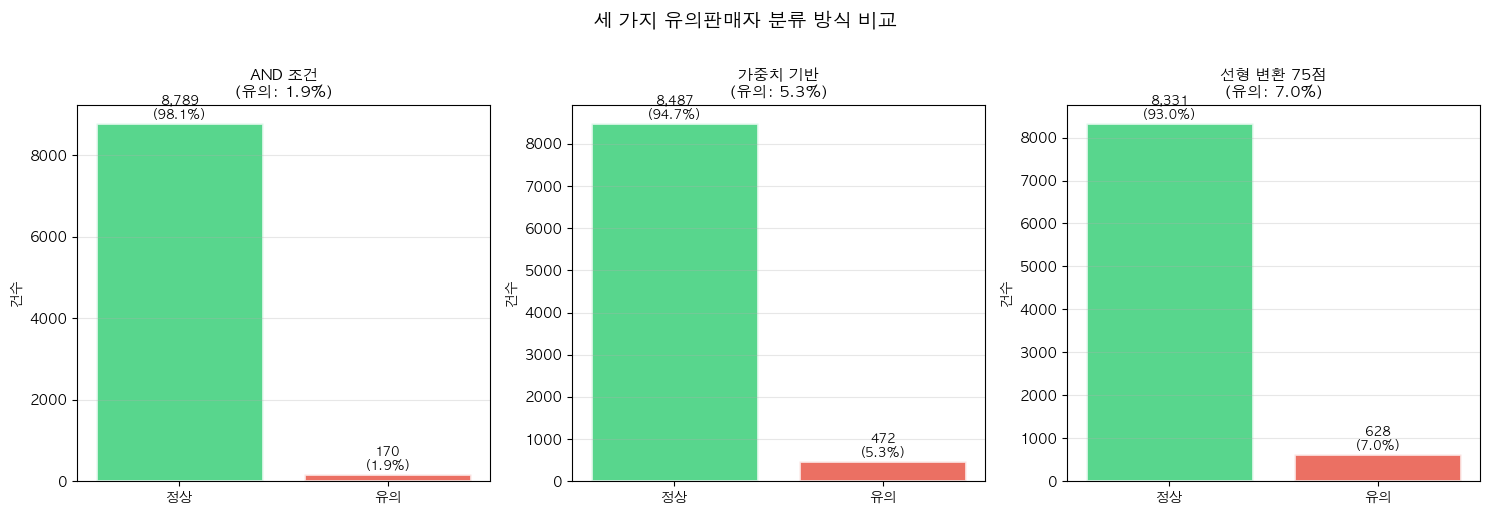

In [2197]:
# 4.6.4 세 가지 Target 비교

print("=" * 80)
print("세 가지 Target 비교")
print("=" * 80)

# NaN 제외한 실제 분포
target_and_valid = monthly_stats['target_is_seller_of_note'].dropna()
target_weighted_valid = monthly_stats['target_is_seller_of_note_weighted'].dropna()
target_linear_valid = monthly_stats['target_is_seller_of_note_linear_75'].dropna()

print("\n[Target 분포 비교]")
print(f"1. 기존 (AND 조건):")
print(f"  - 정상: {(target_and_valid == False).sum():,}건 ({(target_and_valid == False).mean()*100:.1f}%)")
print(f"  - 유의: {(target_and_valid == True).sum():,}건 ({(target_and_valid == True).mean()*100:.1f}%)")

print(f"\n2. 가중치 기반 (Percentile Rank):")
print(f"  - 정상: {(target_weighted_valid == False).sum():,}건 ({(target_weighted_valid == False).mean()*100:.1f}%)")
print(f"  - 유의: {(target_weighted_valid == True).sum():,}건 ({(target_weighted_valid == True).mean()*100:.1f}%)")

print(f"\n3. 선형 변환 기반 (75점 기준):")
print(f"  - 정상: {(target_linear_valid == False).sum():,}건 ({(target_linear_valid == False).mean()*100:.1f}%)")
print(f"  - 유의: {(target_linear_valid == True).sum():,}건 ({(target_linear_valid == True).mean()*100:.1f}%)")

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 세 가지 Target 분포 비교
targets = [
    ('AND 조건', target_and_valid),
    ('가중치 기반', target_weighted_valid),
    ('선형 변환 75점', target_linear_valid)
]

for idx, (title, target) in enumerate(targets):
    ax = axes[idx]
    
    counts = target.value_counts().sort_index()
    normal = counts.get(False, 0)
    note = counts.get(True, 0)
    
    colors = ['#2ecc71', '#e74c3c']
    bars = ax.bar(['정상', '유의'], [normal, note], color=colors, alpha=0.8, edgecolor='white', linewidth=2)
    
    ax.set_ylabel('건수', fontsize=10)
    ax.set_title(f'{title}\n(유의: {note/len(target)*100:.1f}%)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 값 표시
    for bar, val in zip(bars, [normal, note]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 50,
               f'{val:,}\n({val/len(target)*100:.1f}%)', 
               ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('세 가지 유의판매자 분류 방식 비교', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


---
## Step 5. 결측치 처리 및 최종 데이터셋 생성


In [2198]:
# 결측치 현황 확인

print("=" * 80)
print("결측치 현황 (Shift로 인한 NaN)")
print("=" * 80)

null_counts = monthly_stats.isnull().sum()
null_counts = null_counts[null_counts > 0]

print(f"{'컬럼':<35} {'결측치':>10} {'비율':>10}")
print("-" * 55)
for col, count in null_counts.items():
    pct = count / len(monthly_stats) * 100
    print(f"{col:<35} {count:>10,} {pct:>9.1f}%")

print("\n설명:")
print("  - prev_* 컬럼: 각 판매자의 첫 달 데이터는 이전 달이 없어서 NaN")
print("  - next_*, target_*: 각 판매자의 마지막 달 데이터는 다음 달이 없어서 NaN")


결측치 현황 (Shift로 인한 NaN)
컬럼                                         결측치         비율
-------------------------------------------------------
prev_processing_delay_rate               2,635      22.7%
prev_seller_delay_rate                   2,635      22.7%
prev_negative_review_rate                2,635      22.7%
prev_critical_complaint_rate             2,635      22.7%
prev_processing_days_mean                2,635      22.7%
prev_processing_days_std                 2,635      22.7%
prev_order_count                         2,635      22.7%
target_is_seller_of_note                 2,635      22.7%
target_is_seller_of_note_weighted        2,635      22.7%
target_is_seller_of_note_linear_75       2,635      22.7%

설명:
  - prev_* 컬럼: 각 판매자의 첫 달 데이터는 이전 달이 없어서 NaN
  - next_*, target_*: 각 판매자의 마지막 달 데이터는 다음 달이 없어서 NaN


In [2199]:
# 최종 데이터셋 생성 (결측치 제거)

# Lag 피처 (X): 이전 달 데이터
final_feature_cols = [
    # is_Seller_of_Note 조건 관련
    'prev_processing_delay_rate',
    'prev_seller_delay_rate',
    'prev_negative_review_rate',
    # 추가 피처
    'prev_critical_complaint_rate',
    'prev_processing_days_mean', 'prev_processing_days_std',
    'prev_order_count'
]

# Target (y): 다음 달 is_Seller_of_Note
final_cols = ['seller_id', 'year_month'] + final_feature_cols + ['target_is_seller_of_note']

# 결측치 제거
df_final = monthly_stats[final_cols].dropna().copy()

# Target을 int로 변환
df_final['target_is_seller_of_note'] = df_final['target_is_seller_of_note'].astype(int)

print("=" * 80)
print("최종 데이터셋 생성 완료")
print("=" * 80)
print(f"원본 행 수: {len(monthly_stats):,}")
print(f"최종 행 수: {len(df_final):,} (결측치 제거 후)")
print(f"제거된 행: {len(monthly_stats) - len(df_final):,}")
print(f"\n판매자 수: {df_final['seller_id'].nunique():,}명")
print(f"기간: {df_final['year_month'].min()} ~ {df_final['year_month'].max()}")


최종 데이터셋 생성 완료
원본 행 수: 11,594
최종 행 수: 7,038 (결측치 제거 후)
제거된 행: 4,556

판매자 수: 1,484명
기간: 2017-02 ~ 2018-07


In [2200]:
# 최종 데이터셋 확인
print("=" * 80)
print("최종 데이터셋 샘플")
print("=" * 80)
df_final.head(10)


최종 데이터셋 샘플


,seller_id,year_month,prev_processing_delay_rate,prev_seller_delay_rate,prev_negative_review_rate,prev_critical_complaint_rate,prev_processing_days_mean,prev_processing_days_std,prev_order_count,target_is_seller_of_note
1,001cca7ae9ae17fb1caed9dfb1094831,2017-03,0.000000,0.0,0.000000,0.000000,0.950000,0.000000,1.0,0
2,001cca7ae9ae17fb1caed9dfb1094831,2017-04,0.846154,0.0,0.461538,0.307692,3.943077,1.563023,13.0,0
3,001cca7ae9ae17fb1caed9dfb1094831,2017-05,0.090909,0.0,0.363636,0.272727,1.021818,1.019949,11.0,0
4,001cca7ae9ae17fb1caed9dfb1094831,2017-06,0.000000,0.0,0.318182,0.227273,0.846818,0.529028,22.0,0
5,001cca7ae9ae17fb1caed9dfb1094831,2017-07,0.476190,0.0,0.142857,0.047619,2.187619,1.323548,21.0,0
6,001cca7ae9ae17fb1caed9dfb1094831,2017-08,0.071429,0.0,0.214286,0.214286,1.311429,0.820749,14.0,0
7,001cca7ae9ae17fb1caed9dfb1094831,2017-09,0.272727,0.0,0.272727,0.181818,1.528182,0.922657,11.0,0
8,001cca7ae9ae17fb1caed9dfb1094831,2018-01,0.454545,0.0,0.181818,0.090909,2.730909,1.167677,11.0,0
9,001cca7ae9ae17fb1caed9dfb1094831,2018-02,0.400000,0.2,0.000000,0.000000,2.486000,1.247670,5.0,0
10,001cca7ae9ae17fb1caed9dfb1094831,2018-03,0.500000,0.5,0.500000,0.500000,3.990000,2.856711,2.0,0


In [2201]:
# Target 분포 확인
print("=" * 80)
print("Target 분포 (최종)")
print("=" * 80)

target_dist = df_final['target_is_seller_of_note'].value_counts().sort_index()
print(f"0 (정상): {target_dist.get(0, 0):,}건 ({target_dist.get(0, 0)/len(df_final)*100:.1f}%)")
print(f"1 (유의 판매자): {target_dist.get(1, 0):,}건 ({target_dist.get(1, 0)/len(df_final)*100:.1f}%)")


Target 분포 (최종)
0 (정상): 6,893건 (97.9%)
1 (유의 판매자): 145건 (2.1%)


---
## Step 6. 피처 분석


In [2202]:
# 피처 통계
print("=" * 80)
print("피처 통계")
print("=" * 80)
df_final[final_feature_cols].describe().round(3)


피처 통계


,prev_processing_delay_rate,prev_seller_delay_rate,prev_negative_review_rate,prev_critical_complaint_rate,prev_processing_days_mean,prev_processing_days_std,prev_order_count
count,7038.000,7038.000,7038.000,7038.000,7038.000,7038.000,7038.000
mean,0.345,0.076,0.173,0.111,2.573,0.969,6.704
std,0.376,0.212,0.267,0.221,2.416,1.239,11.969
min,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,0.000,0.000,0.000,0.000,1.136,0.000,1.000
50%,0.222,0.000,0.000,0.000,1.858,0.735,3.000
75%,0.625,0.000,0.250,0.143,3.158,1.405,7.000
max,1.000,1.000,1.000,1.000,28.750,19.778,200.000


In [2203]:
# Target별 피처 비교
print("=" * 80)
print("Target별 피처 평균 비교")
print("=" * 80)

comparison = df_final.groupby('target_is_seller_of_note')[final_feature_cols].mean()
comparison.index = ['정상 (0)', '유의 판매자 (1)']
comparison.T.round(4)


Target별 피처 평균 비교


,정상 (0),유의 판매자 (1)
prev_processing_delay_rate,0.3400,0.5932
prev_seller_delay_rate,0.0729,0.1995
prev_negative_review_rate,0.1709,0.2510
prev_critical_complaint_rate,0.1095,0.1675
prev_processing_days_mean,2.5284,4.7108
prev_processing_days_std,0.9481,1.9747
prev_order_count,6.5487,14.0690


In [2204]:
# 피처-Target 상관관계
print("=" * 80)
print("피처-Target 상관관계 (Spearman)")
print("=" * 80)

correlations = df_final[final_feature_cols + ['target_is_seller_of_note']].corr(method='spearman')['target_is_seller_of_note'][:-1]
correlations = correlations.sort_values(key=abs, ascending=False)

print(f"{'피처':<40} {'상관계수':>10}")
print("-" * 50)
for feat, corr in correlations.items():
    direction = '(+)' if corr > 0 else '(-)'
    print(f"{feat:<40} {corr:>8.4f} {direction}")


피처-Target 상관관계 (Spearman)
피처                                             상관계수
--------------------------------------------------
prev_seller_delay_rate                     0.1399 (+)
prev_processing_days_mean                  0.1244 (+)
prev_processing_days_std                   0.1122 (+)
prev_order_count                           0.1050 (+)
prev_processing_delay_rate                 0.0993 (+)
prev_critical_complaint_rate               0.0801 (+)
prev_negative_review_rate                  0.0778 (+)


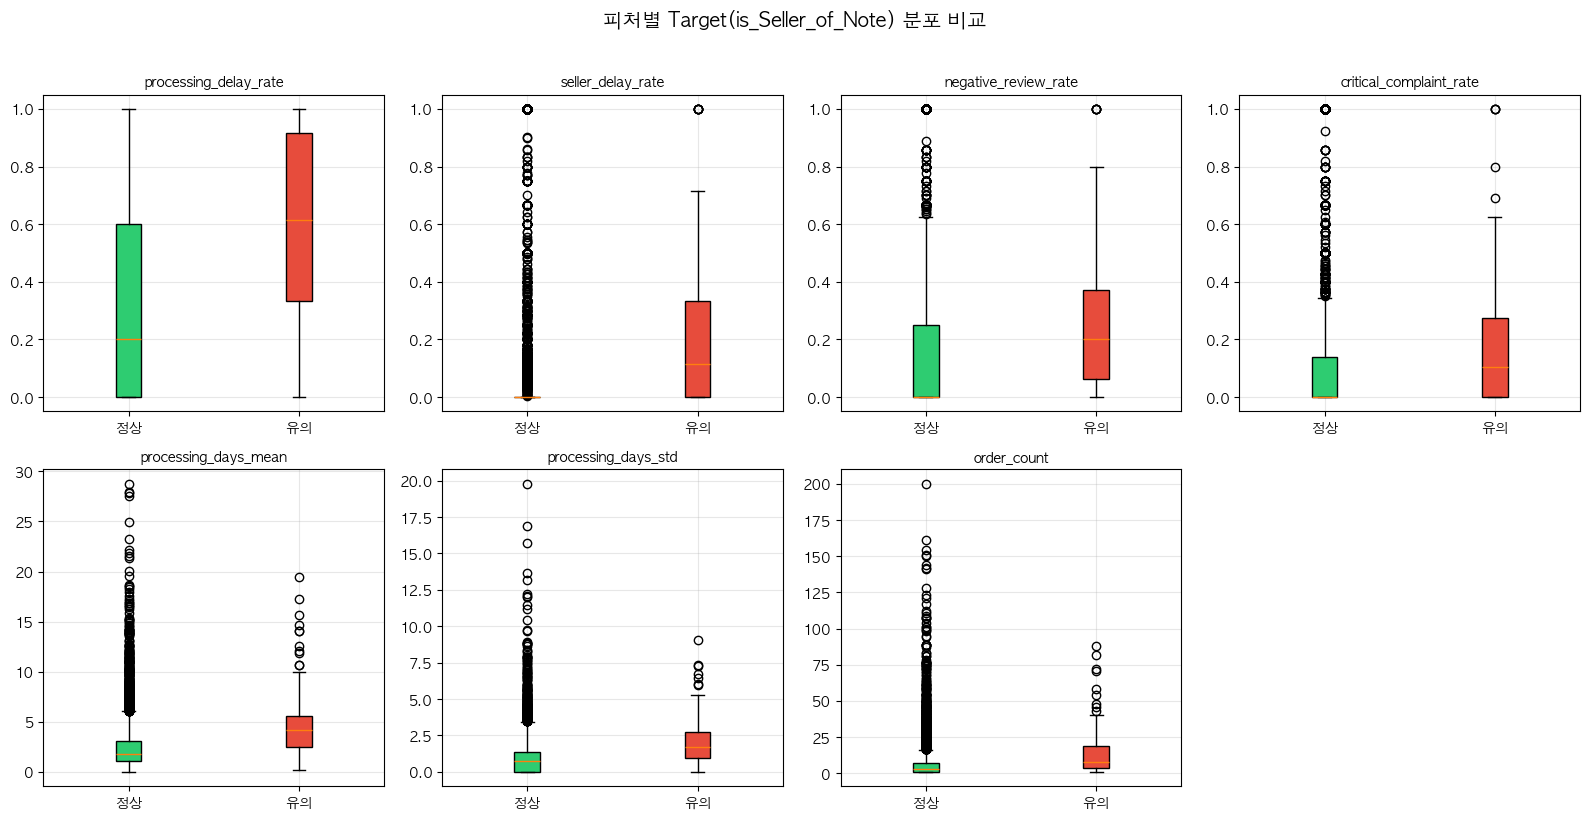

In [2205]:
# 피처별 Target 분포 시각화
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, col in enumerate(final_feature_cols):
    ax = axes[idx // 4, idx % 4]
    
    # Target별 boxplot
    df_0 = df_final[df_final['target_is_seller_of_note'] == 0][col]
    df_1 = df_final[df_final['target_is_seller_of_note'] == 1][col]
    
    bp = ax.boxplot([df_0, df_1], labels=['정상', '유의'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    
    ax.set_title(col.replace('prev_', ''), fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)

# 마지막 빈 subplot 제거
axes[1, 3].axis('off')

plt.suptitle('피처별 Target(is_Seller_of_Note) 분포 비교', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


---
## Step 7. 데이터셋 저장


In [2206]:
# 최종 데이터셋 저장
output_path = 'Olist_DataSet/phase2_train_set.csv'
df_final.to_csv(output_path, index=False)

print("=" * 80)
print("데이터셋 저장 완료")
print("=" * 80)
print(f"저장 경로: {output_path}")
print(f"행 수: {len(df_final):,}")
print(f"열 수: {len(df_final.columns)}")
print(f"\n피처 목록:")
for col in final_feature_cols:
    print(f"  - {col}")
print(f"\nTarget: target_is_seller_of_note (다음 달 is_Seller_of_Note)")


데이터셋 저장 완료
저장 경로: Olist_DataSet/phase2_train_set.csv
행 수: 7,038
열 수: 10

피처 목록:
  - prev_processing_delay_rate
  - prev_seller_delay_rate
  - prev_negative_review_rate
  - prev_critical_complaint_rate
  - prev_processing_days_mean
  - prev_processing_days_std
  - prev_order_count

Target: target_is_seller_of_note (다음 달 is_Seller_of_Note)


---
## Step 8. 모델 학습

### 목표
- 이전 달 피처(X)로 다음 달 is_Seller_of_Note(y) 예측

### 모델
- XGBoost
- LightGBM
- RandomForest

### 평가 지표
- Accuracy, F1-Score, ROC-AUC
- Confusion Matrix, Classification Report


In [2207]:
# 8.1 라이브러리 임포트 및 데이터 준비

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, roc_auc_score, 
                             precision_score, recall_score)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# 피처와 타깃 분리
X = df_final[final_feature_cols]
y = df_final['target_is_seller_of_note']

print("=" * 80)
print("데이터 준비 완료")
print("=" * 80)
print(f"피처 수: {X.shape[1]}")
print(f"샘플 수: {X.shape[0]:,}")
print(f"\nTarget 분포:")
print(f"  0 (정상): {(y == 0).sum():,}건 ({(y == 0).mean()*100:.1f}%)")
print(f"  1 (유의 판매자): {(y == 1).sum():,}건 ({(y == 1).mean()*100:.1f}%)")


데이터 준비 완료
피처 수: 7
샘플 수: 7,038

Target 분포:
  0 (정상): 6,893건 (97.9%)
  1 (유의 판매자): 145건 (2.1%)


In [2208]:
# 8.2 Train/Test 분할 (시간순 분할)

# 시계열 데이터이므로 시간순으로 분할 (미래 데이터 누수 방지)
# df_final은 이미 year_month 순으로 정렬되어 있음

split_idx = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("=" * 80)
print("Train/Test 분할 완료")
print("=" * 80)
print(f"\nTrain: {len(X_train):,}건")
print(f"  - 정상: {(y_train == 0).sum():,}건 ({(y_train == 0).mean()*100:.1f}%)")
print(f"  - 유의: {(y_train == 1).sum():,}건 ({(y_train == 1).mean()*100:.1f}%)")
print(f"\nTest: {len(X_test):,}건")
print(f"  - 정상: {(y_test == 0).sum():,}건 ({(y_test == 0).mean()*100:.1f}%)")
print(f"  - 유의: {(y_test == 1).sum():,}건 ({(y_test == 1).mean()*100:.1f}%)")


Train/Test 분할 완료

Train: 5,630건
  - 정상: 5,513건 (97.9%)
  - 유의: 117건 (2.1%)

Test: 1,408건
  - 정상: 1,380건 (98.0%)
  - 유의: 28건 (2.0%)


In [2209]:
# 8.3 모델 학습 및 평가 함수

def train_and_evaluate(model, model_name, X_train, X_test, y_train, y_test):
    """모델 학습 및 평가"""
    # 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 평가 지표
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    # 결과 출력
    print("=" * 80)
    print(f"[{model_name}] 평가 결과")
    print("=" * 80)
    print(f"\n[성능 지표]")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    print(f"\n[Confusion Matrix]")
    print(f"  TN={cm[0,0]:,}  FP={cm[0,1]:,}")
    print(f"  FN={cm[1,0]:,}  TP={cm[1,1]:,}")
    
    print(f"\n[Classification Report]")
    print(classification_report(y_test, y_pred, target_names=['정상', '유의 판매자']))
    
    return {
        'model_name': model_name,
        'model': model,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

print("평가 함수 정의 완료")


평가 함수 정의 완료


In [2210]:
# 8.4 XGBoost 학습 (클래스 불균형 처리)

# 클래스 비율 계산 (scale_pos_weight)
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"클래스 불균형 비율: 정상({neg_count}) : 유의({pos_count}) = {scale_pos_weight:.1f}:1")

model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # 클래스 불균형 처리
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

result_xgb = train_and_evaluate(model_xgb, 'XGBoost', X_train, X_test, y_train, y_test)


클래스 불균형 비율: 정상(5513) : 유의(117) = 47.1:1
[XGBoost] 평가 결과

[성능 지표]
  Accuracy:  0.9212
  Precision: 0.0722
  Recall:    0.2500
  F1-Score:  0.1120
  ROC-AUC:   0.7267

[Confusion Matrix]
  TN=1,290  FP=90
  FN=21  TP=7

[Classification Report]
              precision    recall  f1-score   support

          정상       0.98      0.93      0.96      1380
      유의 판매자       0.07      0.25      0.11        28

    accuracy                           0.92      1408
   macro avg       0.53      0.59      0.54      1408
weighted avg       0.97      0.92      0.94      1408



In [2211]:
# 8.5 LightGBM 학습 (클래스 불균형 처리)

model_lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    class_weight='balanced',  # 클래스 불균형 처리
    random_state=42,
    verbose=-1
)

result_lgbm = train_and_evaluate(model_lgbm, 'LightGBM', X_train, X_test, y_train, y_test)


[LightGBM] 평가 결과

[성능 지표]
  Accuracy:  0.9141
  Precision: 0.0571
  Recall:    0.2143
  F1-Score:  0.0902
  ROC-AUC:   0.7006

[Confusion Matrix]
  TN=1,281  FP=99
  FN=22  TP=6

[Classification Report]
              precision    recall  f1-score   support

          정상       0.98      0.93      0.95      1380
      유의 판매자       0.06      0.21      0.09        28

    accuracy                           0.91      1408
   macro avg       0.52      0.57      0.52      1408
weighted avg       0.96      0.91      0.94      1408



In [2212]:
# 8.6 RandomForest 학습 (클래스 불균형 처리)

model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # 클래스 불균형 처리
    random_state=42
)

result_rf = train_and_evaluate(model_rf, 'RandomForest', X_train, X_test, y_train, y_test)


[RandomForest] 평가 결과

[성능 지표]
  Accuracy:  0.8849
  Precision: 0.0759
  Recall:    0.4286
  F1-Score:  0.1290
  ROC-AUC:   0.7775

[Confusion Matrix]
  TN=1,234  FP=146
  FN=16  TP=12

[Classification Report]
              precision    recall  f1-score   support

          정상       0.99      0.89      0.94      1380
      유의 판매자       0.08      0.43      0.13        28

    accuracy                           0.88      1408
   macro avg       0.53      0.66      0.53      1408
weighted avg       0.97      0.88      0.92      1408



In [2213]:
# 8.7.1 데이터 준비 (가중치 기반)

# 피처와 타깃 분리
X_weighted = df_final_weighted[final_feature_cols]
y_weighted = df_final_weighted['target_is_seller_of_note_weighted']

print("=" * 80)
print("가중치 기반 데이터 준비 완료")
print("=" * 80)
print(f"피처 수: {X_weighted.shape[1]}")
print(f"샘플 수: {X_weighted.shape[0]:,}")
print(f"\nTarget 분포:")
print(f"  0 (정상): {(y_weighted == 0).sum():,}건 ({(y_weighted == 0).mean()*100:.1f}%)")
print(f"  1 (유의 판매자): {(y_weighted == 1).sum():,}건 ({(y_weighted == 1).mean()*100:.1f}%)")


가중치 기반 데이터 준비 완료
피처 수: 7
샘플 수: 7,038

Target 분포:
  0 (정상): 6,635건 (94.3%)
  1 (유의 판매자): 403건 (5.7%)


In [2214]:
# 8.7.2 Train/Test 분할
# 시계열 데이터이므로 시간순으로 분할 (미래 데이터 누수 방지)
split_idx_weighted = int(len(X_weighted) * 0.8)

X_train_w, X_test_w = X_weighted.iloc[:split_idx_weighted], X_weighted.iloc[split_idx_weighted:]
y_train_w, y_test_w = y_weighted.iloc[:split_idx_weighted], y_weighted.iloc[split_idx_weighted:]

print("=" * 80)
print("Train/Test 분할 완료 (시간순 80:20)")
print("=" * 80)
print(f"\nTrain: {len(X_train_w):,}건")
print(f"  - 정상: {(y_train_w == 0).sum():,}건 ({(y_train_w == 0).mean()*100:.1f}%)")
print(f"  - 유의: {(y_train_w == 1).sum():,}건 ({(y_train_w == 1).mean()*100:.1f}%)")
print(f"\nTest: {len(X_test_w):,}건")
print(f"  - 정상: {(y_test_w == 0).sum():,}건 ({(y_test_w == 0).mean()*100:.1f}%)")
print(f"  - 유의: {(y_test_w == 1).sum():,}건 ({(y_test_w == 1).mean()*100:.1f}%)")


Train/Test 분할 완료 (시간순 80:20)

Train: 5,630건
  - 정상: 5,302건 (94.2%)
  - 유의: 328건 (5.8%)

Test: 1,408건
  - 정상: 1,333건 (94.7%)
  - 유의: 75건 (5.3%)


In [2215]:
# 8.7.3 XGBoost 학습 (가중치 기반)

# 클래스 비율 계산 (scale_pos_weight)
neg_count_w = (y_train_w == 0).sum()
pos_count_w = (y_train_w == 1).sum()
scale_pos_weight_w = neg_count_w / pos_count_w

print(f"클래스 불균형 비율: 정상({neg_count_w}) : 유의({pos_count_w}) = {scale_pos_weight_w:.1f}:1")

model_xgb_w = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight_w,  # 클래스 불균형 처리
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

result_xgb_w = train_and_evaluate(model_xgb_w, 'XGBoost (가중치 기반)', X_train_w, X_test_w, y_train_w, y_test_w)


클래스 불균형 비율: 정상(5302) : 유의(328) = 16.2:1
[XGBoost (가중치 기반)] 평가 결과

[성능 지표]
  Accuracy:  0.8239
  Precision: 0.1050
  Recall:    0.3067
  F1-Score:  0.1565
  ROC-AUC:   0.6156

[Confusion Matrix]
  TN=1,137  FP=196
  FN=52  TP=23

[Classification Report]
              precision    recall  f1-score   support

          정상       0.96      0.85      0.90      1333
      유의 판매자       0.11      0.31      0.16        75

    accuracy                           0.82      1408
   macro avg       0.53      0.58      0.53      1408
weighted avg       0.91      0.82      0.86      1408



In [2216]:
# 8.7.4 LightGBM 학습 (가중치 기반)

model_lgbm_w = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    class_weight='balanced',  # 클래스 불균형 처리
    random_state=42,
    verbose=-1
)

result_lgbm_w = train_and_evaluate(model_lgbm_w, 'LightGBM (가중치 기반)', X_train_w, X_test_w, y_train_w, y_test_w)


[LightGBM (가중치 기반)] 평가 결과

[성능 지표]
  Accuracy:  0.7969
  Precision: 0.1049
  Recall:    0.3733
  F1-Score:  0.1637
  ROC-AUC:   0.6140

[Confusion Matrix]
  TN=1,094  FP=239
  FN=47  TP=28

[Classification Report]
              precision    recall  f1-score   support

          정상       0.96      0.82      0.88      1333
      유의 판매자       0.10      0.37      0.16        75

    accuracy                           0.80      1408
   macro avg       0.53      0.60      0.52      1408
weighted avg       0.91      0.80      0.85      1408



In [2217]:
# 8.7.5 RandomForest 학습 (가중치 기반)

model_rf_w = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # 클래스 불균형 처리
    random_state=42
)

result_rf_w = train_and_evaluate(model_rf_w, 'RandomForest (가중치 기반)', X_train_w, X_test_w, y_train_w, y_test_w)


[RandomForest (가중치 기반)] 평가 결과

[성능 지표]
  Accuracy:  0.8011
  Precision: 0.1300
  Recall:    0.4800
  F1-Score:  0.2045
  ROC-AUC:   0.6869

[Confusion Matrix]
  TN=1,092  FP=241
  FN=39  TP=36

[Classification Report]
              precision    recall  f1-score   support

          정상       0.97      0.82      0.89      1333
      유의 판매자       0.13      0.48      0.20        75

    accuracy                           0.80      1408
   macro avg       0.55      0.65      0.55      1408
weighted avg       0.92      0.80      0.85      1408



---

## Step 8.8. SMOTE를 이용한 클래스 불균형 해결

### 문제점
- 가중치 기반 모델의 유의 판매자 클래스 성능이 낮음
  - Precision: 0.13, Recall: 0.48, F1-Score: 0.20
- 심각한 클래스 불균형: 정상(1,333) vs 유의(75) ≈ 18:1

### 해결 방법
- SMOTE (Synthetic Minority Over-sampling Technique) 적용
- 소수 클래스의 합성 샘플 생성으로 균형 맞춤
- Train 데이터에만 적용 (Test는 원본 유지)

### 기대 효과
- 유의 판매자 클래스의 Precision 및 F1-Score 향상
- False Negative 감소


In [2218]:
# 8.8.1 SMOTE 적용
from imblearn.over_sampling import SMOTE

print("=" * 80)
print("SMOTE 적용 전 데이터 분포")
print("=" * 80)
print(f"Train 데이터:")
print(f"  정상: {(y_train_w == 0).sum():,}건 ({(y_train_w == 0).mean()*100:.1f}%)")
print(f"  유의: {(y_train_w == 1).sum():,}건 ({(y_train_w == 1).mean()*100:.1f}%)")
print(f"  비율: {(y_train_w == 0).sum() / (y_train_w == 1).sum():.1f}:1")

# SMOTE 적용 (Train 데이터에만)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_w, y_train_w)

print("\n" + "=" * 80)
print("SMOTE 적용 후 데이터 분포")
print("=" * 80)
print(f"Train 데이터:")
print(f"  정상: {(y_train_smote == 0).sum():,}건 ({(y_train_smote == 0).mean()*100:.1f}%)")
print(f"  유의: {(y_train_smote == 1).sum():,}건 ({(y_train_smote == 1).mean()*100:.1f}%)")
print(f"  비율: {(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.1f}:1")

print("\n[주의사항]")
print("  - Test 데이터는 원본 그대로 유지 (Data Leakage 방지)")
print("  - SMOTE는 Train 데이터에만 적용되어 합성 샘플 생성")
print(f"  - 원본 Train: {len(X_train_w):,}건 → SMOTE 후: {len(X_train_smote):,}건 (증가: {len(X_train_smote) - len(X_train_w):,}건)")


SMOTE 적용 전 데이터 분포
Train 데이터:
  정상: 5,302건 (94.2%)
  유의: 328건 (5.8%)
  비율: 16.2:1

SMOTE 적용 후 데이터 분포
Train 데이터:
  정상: 5,302건 (50.0%)
  유의: 5,302건 (50.0%)
  비율: 1.0:1

[주의사항]
  - Test 데이터는 원본 그대로 유지 (Data Leakage 방지)
  - SMOTE는 Train 데이터에만 적용되어 합성 샘플 생성
  - 원본 Train: 5,630건 → SMOTE 후: 10,604건 (증가: 4,974건)


In [2219]:
# 8.8.6 SMOTE 적용 전후 성능 비교

# SMOTE 적용 전 (기존 가중치 기반 모델)
results_before = {
    'XGBoost': {
        'precision': result_xgb_w['precision'], 
        'recall': result_xgb_w['recall'], 
        'f1_score': result_xgb_w['f1_score']
    },
    'LightGBM': {
        'precision': result_lgbm_w['precision'],
        'recall': result_lgbm_w['recall'],
        'f1_score': result_lgbm_w['f1_score']
    },
    'RandomForest': {
        'precision': result_rf_w['precision'],
        'recall': result_rf_w['recall'],
        'f1_score': result_rf_w['f1_score']
    }
}

# SMOTE 적용 후
results_after = {
    'XGBoost': {'precision': prec_xgb_smote, 'recall': rec_xgb_smote, 'f1_score': f1_xgb_smote},
    'LightGBM': {'precision': prec_lgbm_smote, 'recall': rec_lgbm_smote, 'f1_score': f1_lgbm_smote},
    'RandomForest': {'precision': prec_rf_smote, 'recall': rec_rf_smote, 'f1_score': f1_rf_smote}
}

# 비교 DataFrame 생성
comparison_data = []
for model in ['XGBoost', 'LightGBM', 'RandomForest']:
    comparison_data.append({
        'Model': model,
        'Precision_Before': results_before[model]['precision'],
        'Precision_After': results_after[model]['precision'],
        'Recall_Before': results_before[model]['recall'],
        'Recall_After': results_after[model]['recall'],
        'F1_Before': results_before[model]['f1_score'],
        'F1_After': results_after[model]['f1_score']
    })

comparison_df = pd.DataFrame(comparison_data)

print("=" * 80)
print("SMOTE 적용 전후 성능 비교")
print("=" * 80)
print(comparison_df.round(4).to_string(index=False))

# 개선율 계산
print("\n" + "=" * 80)
print("개선율 (% 증가)")
print("=" * 80)
for model in ['XGBoost', 'LightGBM', 'RandomForest']:
    prec_improvement = (results_after[model]['precision'] - results_before[model]['precision']) / results_before[model]['precision'] * 100
    recall_improvement = (results_after[model]['recall'] - results_before[model]['recall']) / results_before[model]['recall'] * 100
    f1_improvement = (results_after[model]['f1_score'] - results_before[model]['f1_score']) / results_before[model]['f1_score'] * 100
    
    print(f"\n[{model}]")
    print(f"  Precision: {prec_improvement:+.1f}%")
    print(f"  Recall:    {recall_improvement:+.1f}%")
    print(f"  F1-Score:  {f1_improvement:+.1f}%")


SMOTE 적용 전후 성능 비교
       Model  Precision_Before  Precision_After  Recall_Before  Recall_After  F1_Before  F1_After
     XGBoost            0.1050           0.1047         0.3067        0.2400     0.1565    0.1457
    LightGBM            0.1049           0.1071         0.3733        0.2000     0.1637    0.1395
RandomForest            0.1300           0.1144         0.4800        0.4133     0.2045    0.1792

개선율 (% 증가)

[XGBoost]
  Precision: -0.4%
  Recall:    -21.7%
  F1-Score:  -6.8%

[LightGBM]
  Precision: +2.2%
  Recall:    -46.4%
  F1-Score:  -14.8%

[RandomForest]
  Precision: -12.0%
  Recall:    -13.9%
  F1-Score:  -12.4%


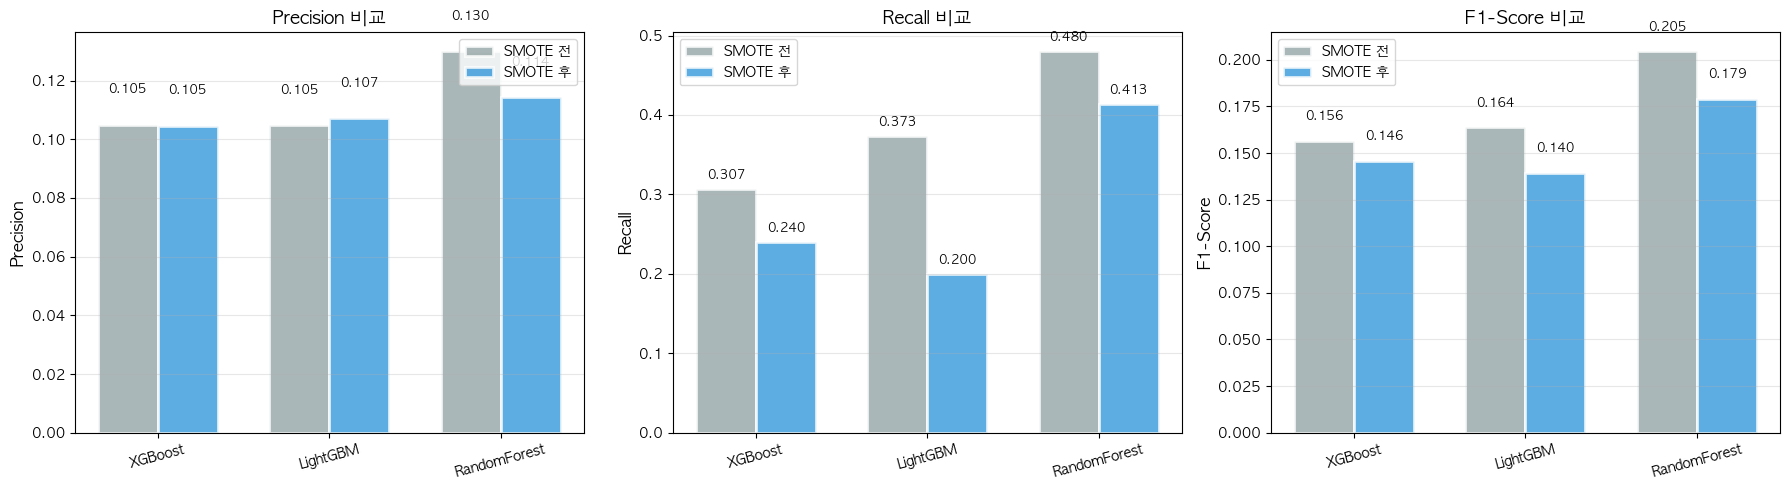

In [2220]:
# 8.8.7 SMOTE 전후 성능 시각화

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['XGBoost', 'LightGBM', 'RandomForest']
metrics = ['Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    before_values = [results_before[m][metric.lower().replace('-', '_')] for m in models]
    after_values = [results_after[m][metric.lower().replace('-', '_')] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, before_values, width, label='SMOTE 전', 
                   color='#95a5a6', alpha=0.8, edgecolor='white', linewidth=2)
    bars2 = ax.bar(x + width/2, after_values, width, label='SMOTE 후', 
                   color='#3498db', alpha=0.8, edgecolor='white', linewidth=2)
    
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} 비교', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 값 표시
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


---

## Step 8.9. 피처 엔지니어링을 통한 성능 개선

### 문제 진단
- 기존 7개 피처만으로는 정보가 부족
- 유의 판매자의 **시간적 추세**와 **패턴 변화**를 포착하지 못함

### 해결 방안
1. **이동 평균 피처**: 최근 2-3개월 평균으로 안정적인 추세 파악
2. **변화율 피처**: 이전 달 대비 증감률로 악화/개선 추세 감지
3. **상호작용 피처**: 여러 지표의 곱셈으로 복합적 위험 포착
4. **시간 피처**: 월, 분기 등 계절성 반영


In [2221]:
# 8.9.1 이동 평균 피처 생성 - 준비

print("=" * 80)
print("8.9.1 이동 평균 피처 - 데이터 준비")
print("=" * 80)

# 시간순 정렬
monthly_stats_enhanced = monthly_stats.sort_values(['seller_id', 'year_month']).copy()

# 이동 평균 계산할 컬럼
cols = ['processing_delay_rate', 'seller_delay_rate', 'negative_review_rate']

print(f"총 {len(monthly_stats_enhanced):,}행")
print(f"이동 평균 대상: {len(cols)}개 컬럼")

8.9.1 이동 평균 피처 - 데이터 준비
총 11,594행
이동 평균 대상: 3개 컬럼


In [2222]:
# 8.9.1-1 이동 평균: 2개월

# 각 컬럼에 대해 2개월 이동 평균 계산
for col in cols:
    # 판매자별로 그룹화해서 이동 평균 계산
    monthly_stats_enhanced[f'{col}_rolling_2'] = monthly_stats_enhanced.groupby('seller_id')[col].rolling(2, min_periods=1).mean().values

print("2개월 이동 평균 완료 (3개 컬럼)")


2개월 이동 평균 완료 (3개 컬럼)


In [2223]:
# 8.9.1-2 이동 평균: 3개월

# 각 컬럼에 대해 3개월 이동 평균 계산
for col in cols:
    monthly_stats_enhanced[f'{col}_rolling_3'] = monthly_stats_enhanced.groupby('seller_id')[col].rolling(3, min_periods=1).mean().values

print("3개월 이동 평균 완료 (3개 컬럼)")
print(f"\n총 추가 피처: 6개 (2개월 3개 + 3개월 3개)")


3개월 이동 평균 완료 (3개 컬럼)

총 추가 피처: 6개 (2개월 3개 + 3개월 3개)


In [2224]:
# 8.9.2 변화율 피처 생성

print("\n" + "=" * 80)
print("8.9.2 변화율 (이전 달 대비)")
print("=" * 80)

# 변화율 계산할 컬럼
change_cols = ['processing_delay_rate', 'seller_delay_rate', 'negative_review_rate', 'order_count']

for col in change_cols:
    # 이전 달 값 가져오기
    prev = monthly_stats_enhanced.groupby('seller_id')[col].shift(1)
    # 변화율 = (현재 - 이전) / 이전
    monthly_stats_enhanced[f'{col}_change'] = (monthly_stats_enhanced[col] - prev) / prev
    # 0으로 나누기 방지 (NaN을 0으로)
    monthly_stats_enhanced[f'{col}_change'] = monthly_stats_enhanced[f'{col}_change'].fillna(0)

print(f"변화율 피처 {len(change_cols)}개 생성 완료")



8.9.2 변화율 (이전 달 대비)
변화율 피처 4개 생성 완료


In [2225]:
# 8.9.3 상호작용 피처 생성

print("\n" + "=" * 80)
print("8.9.3 상호작용 피처 (조합)")
print("=" * 80)

# 지연율과 리뷰 조합
monthly_stats_enhanced['delay_negative_interaction'] = (
    monthly_stats_enhanced['seller_delay_rate'] * monthly_stats_enhanced['negative_review_rate']
)

# 두 가지 지연율 조합
monthly_stats_enhanced['processing_seller_delay_interaction'] = (
    monthly_stats_enhanced['processing_delay_rate'] * monthly_stats_enhanced['seller_delay_rate']
)

# 전체 위험 점수
monthly_stats_enhanced['total_risk_score'] = (
    monthly_stats_enhanced['processing_delay_rate'] * 
    monthly_stats_enhanced['seller_delay_rate'] * 
    monthly_stats_enhanced['negative_review_rate']
)

# 평균 지연율
monthly_stats_enhanced['avg_delay_rate'] = (
    monthly_stats_enhanced['processing_delay_rate'] + monthly_stats_enhanced['seller_delay_rate']
) / 2

print("상호작용 피처 4개 생성 완료")



8.9.3 상호작용 피처 (조합)
상호작용 피처 4개 생성 완료


In [2226]:
# 8.9.4 시간 피처 생성

print("\n" + "=" * 80)
print("8.9.4 시간 피처 (월, 분기 등)")
print("=" * 80)

# year_month를 datetime으로 변환
monthly_stats_enhanced['year_month_str'] = monthly_stats_enhanced['year_month'].astype(str) + '-01'
monthly_stats_enhanced['year_month_dt'] = pd.to_datetime(monthly_stats_enhanced['year_month_str'])

# 월, 분기 추출
monthly_stats_enhanced['month'] = monthly_stats_enhanced['year_month_dt'].dt.month
monthly_stats_enhanced['quarter'] = monthly_stats_enhanced['year_month_dt'].dt.quarter

# 상반기 여부
monthly_stats_enhanced['is_month_start'] = (monthly_stats_enhanced['month'] <= 6).astype(int)

# 판매자 활동 개월 수
monthly_stats_enhanced['seller_tenure_months'] = monthly_stats_enhanced.groupby('seller_id').cumcount() + 1

print("시간 피처 4개 생성 완료")



8.9.4 시간 피처 (월, 분기 등)
시간 피처 4개 생성 완료


In [2227]:
# 8.9.5 Target 생성 및 Lag 피처 적용

print("\n" + "=" * 80)
print("8.9.5 Target 생성 및 Lag 피처 적용")
print("=" * 80)

# 선형 40점 기준 Target (이미 존재함)
# 다음 달 Target 생성
monthly_stats_enhanced['target_is_seller_of_note_linear_75'] = monthly_stats_enhanced.groupby('seller_id')['is_seller_of_note_linear_75'].shift(-1)

# 모든 피처에 대해 Lag 적용 (shift(1) = 이전 달)
enhanced_feature_cols = [
    # 기존 피처
    'processing_delay_rate',
    'seller_delay_rate',
    'negative_review_rate',
    'critical_complaint_rate',
    'processing_days_mean',
    'processing_days_std',
    'order_count',
    # 이동 평균 피처 (6개)
    'processing_delay_rate_rolling_2',
    'processing_delay_rate_rolling_3',
    'seller_delay_rate_rolling_2',
    'seller_delay_rate_rolling_3',
    'negative_review_rate_rolling_2',
    'negative_review_rate_rolling_3',
    # 변화율 피처 (4개)
    'processing_delay_rate_change',
    'seller_delay_rate_change',
    'negative_review_rate_change',
    'order_count_change',
    # 상호작용 피처 (4개)
    'delay_negative_interaction',
    'processing_seller_delay_interaction',
    'total_risk_score',
    'avg_delay_rate',
    # 시간 피처 (4개)
    'month',
    'quarter',
    'is_month_start',
    'seller_tenure_months'
]

# Lag 피처 생성
for col in enhanced_feature_cols:
    if col not in ['month', 'quarter', 'is_month_start', 'seller_tenure_months']:  # 시간 피처는 Lag 적용 안 함
        monthly_stats_enhanced[f'prev_{col}'] = monthly_stats_enhanced.groupby('seller_id')[col].shift(1)
    else:
        # 시간 피처는 그대로 사용
        monthly_stats_enhanced[f'prev_{col}'] = monthly_stats_enhanced[col]



8.9.5 Target 생성 및 Lag 피처 적용


In [2228]:
# 8.9.6 최종 데이터셋 생성

print("\n" + "=" * 80)
print("8.9.6 최종 데이터셋 생성")
print("=" * 80)

# 최종 피처 컬럼 정의 (prev_ 접두어 추가)
final_enhanced_feature_cols = [f'prev_{col}' for col in enhanced_feature_cols]

# 데이터셋 생성
final_cols_enhanced = ['seller_id', 'year_month'] + final_enhanced_feature_cols + ['target_is_seller_of_note_linear_75']

# 결측치 제거
df_final_enhanced = monthly_stats_enhanced[final_cols_enhanced].dropna().copy()

# Target을 int로 변환
df_final_enhanced['target_is_seller_of_note_linear_75'] = df_final_enhanced['target_is_seller_of_note_linear_75'].astype(int)

print(f"\n[데이터셋 생성 완료]")
print(f"  - 전체 행 수: {len(monthly_stats_enhanced):,}")
print(f"  - 결측치 제거 후: {len(df_final_enhanced):,}")
print(f"  - 제거된 행: {len(monthly_stats_enhanced) - len(df_final_enhanced):,}")
print(f"  - 피처 개수: {len(final_enhanced_feature_cols)}개")

# Target 분포
print(f"\n[Target 분포 (최종)]")
target_counts = df_final_enhanced['target_is_seller_of_note_linear_75'].value_counts()
print(target_counts)
print(f"\n정상: {target_counts.get(0, 0):,}건 ({target_counts.get(0, 0)/len(df_final_enhanced)*100:.2f}%)")
print(f"유의 판매자: {target_counts.get(1, 0):,}건 ({target_counts.get(1, 0)/len(df_final_enhanced)*100:.2f}%)")
print(f"불균형 비율: {target_counts.get(0, 0) / target_counts.get(1, 1):.1f} : 1")



8.9.6 최종 데이터셋 생성

[데이터셋 생성 완료]
  - 전체 행 수: 11,594
  - 결측치 제거 후: 7,038
  - 제거된 행: 4,556
  - 피처 개수: 25개

[Target 분포 (최종)]
target_is_seller_of_note_linear_75
0    6577
1     461
Name: count, dtype: int64

정상: 6,577건 (93.45%)
유의 판매자: 461건 (6.55%)
불균형 비율: 14.3 : 1


In [2229]:
# 8.9.7 Train/Test 분할 및 모델 학습

print("\n" + "=" * 80)
print("8.9.7 데이터 준비 및 Train/Test 분할")
print("=" * 80)

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# 피처와 타깃 분리
X_enhanced = df_final_enhanced[final_enhanced_feature_cols]
y_enhanced = df_final_enhanced['target_is_seller_of_note_linear_75']

print(f"[데이터 준비 완료]")
print(f"  - X shape: {X_enhanced.shape}")
print(f"  - y shape: {y_enhanced.shape}")
print(f"  - 피처 수: {X_enhanced.shape[1]}개 (기존 7개 → {X_enhanced.shape[1]}개)")

# Train/Test 분할 (80:20, 시계열 순서 유지)
split_idx = int(len(X_enhanced) * 0.8)
X_train_enh = X_enhanced.iloc[:split_idx]
X_test_enh = X_enhanced.iloc[split_idx:]
y_train_enh = y_enhanced.iloc[:split_idx]
y_test_enh = y_enhanced.iloc[split_idx:]

print(f"\n[Train/Test 분할]")
print(f"  - Train: {len(X_train_enh):,}건 ({len(X_train_enh)/len(X_enhanced)*100:.1f}%)")
print(f"  - Test:  {len(X_test_enh):,}건 ({len(X_test_enh)/len(X_enhanced)*100:.1f}%)")
print(f"\n[Train Target 분포]")
print(f"  - 정상: {(y_train_enh == 0).sum():,}건 ({(y_train_enh == 0).mean()*100:.2f}%)")
print(f"  - 유의 판매자: {(y_train_enh == 1).sum():,}건 ({(y_train_enh == 1).mean()*100:.2f}%)")
print(f"\n[Test Target 분포]")
print(f"  - 정상: {(y_test_enh == 0).sum():,}건 ({(y_test_enh == 0).mean()*100:.2f}%)")
print(f"  - 유의 판매자: {(y_test_enh == 1).sum():,}건 ({(y_test_enh == 1).mean()*100:.2f}%)")

# 클래스 가중치 계산
n_samples = len(y_train_enh)
n_positive = (y_train_enh == 1).sum()
n_negative = (y_train_enh == 0).sum()
scale_pos_weight_enh = n_negative / n_positive

print(f"\n[클래스 불균형 대응]")
print(f"  - scale_pos_weight: {scale_pos_weight_enh:.2f}")



8.9.7 데이터 준비 및 Train/Test 분할
[데이터 준비 완료]
  - X shape: (7038, 25)
  - y shape: (7038,)
  - 피처 수: 25개 (기존 7개 → 25개)

[Train/Test 분할]
  - Train: 5,630건 (80.0%)
  - Test:  1,408건 (20.0%)

[Train Target 분포]
  - 정상: 5,251건 (93.27%)
  - 유의 판매자: 379건 (6.73%)

[Test Target 분포]
  - 정상: 1,326건 (94.18%)
  - 유의 판매자: 82건 (5.82%)

[클래스 불균형 대응]
  - scale_pos_weight: 13.85


In [2230]:
# 8.9.8 모델 학습 (3개 모델 한번에)

print("\n" + "=" * 80)
print("8.9.8 모델 학습 (XGBoost, LightGBM, RandomForest)")
print("=" * 80)

# 모델 정의
models = {
    'XGBoost': XGBClassifier(
        scale_pos_weight=scale_pos_weight_enh,
        max_depth=6,
        n_estimators=200,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    ),
    'LightGBM': LGBMClassifier(
        class_weight='balanced',
        max_depth=6,
        n_estimators=200,
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    ),
    'RandomForest': RandomForestClassifier(
        class_weight='balanced',
        max_depth=10,
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
}

# 각 모델 학습 및 평가
results_models = {}
for name, model in models.items():
    print(f"\n{name} 학습 중...")
    
    # 학습
    model.fit(X_train_enh, y_train_enh)
    
    # 예측
    y_pred = model.predict(X_test_enh)
    y_pred_proba = model.predict_proba(X_test_enh)[:, 1]
    
    # 성능 평가
    results_models[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'precision': precision_score(y_test_enh, y_pred),
        'recall': recall_score(y_test_enh, y_pred),
        'f1_score': f1_score(y_test_enh, y_pred),
        'roc_auc': roc_auc_score(y_test_enh, y_pred_proba)
    }
    
    print(f"  Precision: {results_models[name]['precision']:.4f}")
    print(f"  Recall:    {results_models[name]['recall']:.4f}")
    print(f"  F1-Score:  {results_models[name]['f1_score']:.4f}")

# 각 모델의 변수 저장 (기존 코드 호환성)
model_xgb_enh = results_models['XGBoost']['model']
model_lgbm_enh = results_models['LightGBM']['model']
model_rf_enh = results_models['RandomForest']['model']

y_pred_xgb_enh = results_models['XGBoost']['y_pred']
y_pred_lgbm_enh = results_models['LightGBM']['y_pred']
y_pred_rf_enh = results_models['RandomForest']['y_pred']

y_pred_proba_xgb_enh = results_models['XGBoost']['y_pred_proba']
y_pred_proba_lgbm_enh = results_models['LightGBM']['y_pred_proba']
y_pred_proba_rf_enh = results_models['RandomForest']['y_pred_proba']

prec_xgb_enh = results_models['XGBoost']['precision']
prec_lgbm_enh = results_models['LightGBM']['precision']
prec_rf_enh = results_models['RandomForest']['precision']

rec_xgb_enh = results_models['XGBoost']['recall']
rec_lgbm_enh = results_models['LightGBM']['recall']
rec_rf_enh = results_models['RandomForest']['recall']

f1_xgb_enh = results_models['XGBoost']['f1_score']
f1_lgbm_enh = results_models['LightGBM']['f1_score']
f1_rf_enh = results_models['RandomForest']['f1_score']

roc_auc_xgb_enh = results_models['XGBoost']['roc_auc']
roc_auc_lgbm_enh = results_models['LightGBM']['roc_auc']
roc_auc_rf_enh = results_models['RandomForest']['roc_auc']

print("\n모델 학습 완료")



8.9.8 모델 학습 (XGBoost, LightGBM, RandomForest)

XGBoost 학습 중...


XGBoostError: [17:02:40] /opt/miniconda3/conda-bld/xgboost-split_1764761376052/work/src/data/gradient_index.h:100: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000032cadaa28 dmlc::LogMessageFatal::~LogMessageFatal() + 140
  [bt] (1) 2   libxgboost.dylib                    0x000000032cce1bf8 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::EncColumnarAdapterBatchImpl<xgboost::NoOpAccessor>, unsigned char, xgboost::common::Index::CompressBin<unsigned char>, xgboost::data::IsValidFunctor&>(xgboost::common::Span<unsigned char, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::EncColumnarAdapterBatchImpl<xgboost::NoOpAccessor> const&, xgboost::data::IsValidFunctor&, unsigned long, xgboost::common::Index::CompressBin<unsigned char>&&) + 368
  [bt] (2) 3   libxgboost.dylib                    0x000000032cce1768 auto xgboost::common::DispatchBinType<void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::EncColumnarAdapterBatchImpl<xgboost::NoOpAccessor>, xgboost::data::IsValidFunctor&>(int, xgboost::data::EncColumnarAdapterBatchImpl<xgboost::NoOpAccessor> const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::EncColumnarAdapterBatchImpl<xgboost::NoOpAccessor>)>(xgboost::common::BinTypeSize, xgboost::data::EncColumnarAdapterBatchImpl<xgboost::NoOpAccessor>&&) + 136
  [bt] (3) 4   libxgboost.dylib                    0x000000032cce03cc void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::EncColumnarAdapterBatchImpl<xgboost::NoOpAccessor>, xgboost::data::IsValidFunctor&>(int, xgboost::data::EncColumnarAdapterBatchImpl<xgboost::NoOpAccessor> const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 368
  [bt] (4) 5   libxgboost.dylib                    0x000000032ccdfe8c void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::EncColumnarAdapterBatchImpl<xgboost::NoOpAccessor>>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::EncColumnarAdapterBatchImpl<xgboost::NoOpAccessor> const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long long) + 316
  [bt] (5) 6   libxgboost.dylib                    0x000000032cce84f4 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, xgboost::data::DataIterProxy<void (void*), int (void*)>&&, float, std::__1::shared_ptr<xgboost::DMatrix>) + 2524
  [bt] (6) 7   libxgboost.dylib                    0x000000032cce75f8 xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int, long long) + 972
  [bt] (7) 8   libxgboost.dylib                    0x000000032cc6fdc4 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int, long long) + 172
  [bt] (8) 9   libxgboost.dylib                    0x000000032cae5db8 XGQuantileDMatrixCreateFromCallback + 528



In [ ]:
# 8.9.9 LightGBM 모델 학습 

print("\n" + "=" * 80)
print("8.9.9 LightGBM 모델 학습 (25개 피처)")
print("=" * 80)

# LightGBM 모델 초기화 및 학습
model_lgbm_enh = LGBMClassifier(
    class_weight='balanced',
    max_depth=6,  # 더 깊은 트리
    n_estimators=200,  # 더 많은 트리
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)

model_lgbm_enh.fit(X_train_enh, y_train_enh)

# 예측
y_pred_lgbm_enh = model_lgbm_enh.predict(X_test_enh)
y_pred_proba_lgbm_enh = model_lgbm_enh.predict_proba(X_test_enh)[:, 1]

# 성능 평가
acc_lgbm_enh = accuracy_score(y_test_enh, y_pred_lgbm_enh)
prec_lgbm_enh = precision_score(y_test_enh, y_pred_lgbm_enh)
rec_lgbm_enh = recall_score(y_test_enh, y_pred_lgbm_enh)
f1_lgbm_enh = f1_score(y_test_enh, y_pred_lgbm_enh)
roc_auc_lgbm_enh = roc_auc_score(y_test_enh, y_pred_proba_lgbm_enh)
cm_lgbm_enh = confusion_matrix(y_test_enh, y_pred_lgbm_enh)

print(f"\n[LightGBM 성능 (Enhanced)]")
print(f"  - Accuracy:  {acc_lgbm_enh:.4f}")
print(f"  - Precision: {prec_lgbm_enh:.4f}")
print(f"  - Recall:    {rec_lgbm_enh:.4f}")
print(f"  - F1-Score:  {f1_lgbm_enh:.4f}")
print(f"  - ROC-AUC:   {roc_auc_lgbm_enh:.4f}")

print(f"\n[Confusion Matrix]")
print(f"  TN={cm_lgbm_enh[0,0]:,}  FP={cm_lgbm_enh[0,1]:,}")
print(f"  FN={cm_lgbm_enh[1,0]:,}  TP={cm_lgbm_enh[1,1]:,}")

print(f"\n[Classification Report]")
print(classification_report(y_test_enh, y_pred_lgbm_enh, target_names=['정상', '유의 판매자']))



8.9.9 LightGBM 모델 학습 (25개 피처)

[LightGBM 성능 (Enhanced)]
  - Accuracy:  0.8893
  - Precision: 0.1325
  - Recall:    0.1774
  - F1-Score:  0.1517
  - ROC-AUC:   0.6920

[Confusion Matrix]
  TN=977  FP=72
  FN=51  TP=11

[Classification Report]
              precision    recall  f1-score   support

          정상       0.95      0.93      0.94      1049
      유의 판매자       0.13      0.18      0.15        62

    accuracy                           0.89      1111
   macro avg       0.54      0.55      0.55      1111
weighted avg       0.90      0.89      0.90      1111



In [ ]:
# 8.9.10 RandomForest 모델 학습 

print("\n" + "=" * 80)
print("8.9.10 RandomForest 모델 학습 (25개 피처)")
print("=" * 80)

# RandomForest 모델 초기화 및 학습
model_rf_enh = RandomForestClassifier(
    class_weight='balanced',
    max_depth=10,  # 더 깊은 트리
    n_estimators=200,  # 더 많은 트리
    random_state=42,
    n_jobs=-1
)

model_rf_enh.fit(X_train_enh, y_train_enh)

# 예측
y_pred_rf_enh = model_rf_enh.predict(X_test_enh)
y_pred_proba_rf_enh = model_rf_enh.predict_proba(X_test_enh)[:, 1]

# 성능 평가
acc_rf_enh = accuracy_score(y_test_enh, y_pred_rf_enh)
prec_rf_enh = precision_score(y_test_enh, y_pred_rf_enh)
rec_rf_enh = recall_score(y_test_enh, y_pred_rf_enh)
f1_rf_enh = f1_score(y_test_enh, y_pred_rf_enh)
roc_auc_rf_enh = roc_auc_score(y_test_enh, y_pred_proba_rf_enh)
cm_rf_enh = confusion_matrix(y_test_enh, y_pred_rf_enh)

print(f"\n[RandomForest 성능 (Enhanced)]")
print(f"  - Accuracy:  {acc_rf_enh:.4f}")
print(f"  - Precision: {prec_rf_enh:.4f}")
print(f"  - Recall:    {rec_rf_enh:.4f}")
print(f"  - F1-Score:  {f1_rf_enh:.4f}")
print(f"  - ROC-AUC:   {roc_auc_rf_enh:.4f}")

print(f"\n[Confusion Matrix]")
print(f"  TN={cm_rf_enh[0,0]:,}  FP={cm_rf_enh[0,1]:,}")
print(f"  FN={cm_rf_enh[1,0]:,}  TP={cm_rf_enh[1,1]:,}")

print(f"\n[Classification Report]")
print(classification_report(y_test_enh, y_pred_rf_enh, target_names=['정상', '유의 판매자']))



8.9.10 RandomForest 모델 학습 (25개 피처)

[RandomForest 성능 (Enhanced)]
  - Accuracy:  0.9190
  - Precision: 0.2500
  - Recall:    0.2258
  - F1-Score:  0.2373
  - ROC-AUC:   0.7564

[Confusion Matrix]
  TN=1,007  FP=42
  FN=48  TP=14

[Classification Report]
              precision    recall  f1-score   support

          정상       0.95      0.96      0.96      1049
      유의 판매자       0.25      0.23      0.24        62

    accuracy                           0.92      1111
   macro avg       0.60      0.59      0.60      1111
weighted avg       0.92      0.92      0.92      1111



In [ ]:
# 8.9.15 Threshold 조정으로 Recall 개선
print("\n" + "=" * 80)
print("8.9.15 Threshold 조정으로 Recall 개선")
print("=" * 80)

# RandomForest (최고 성능 모델) 사용
y_pred_proba = y_pred_proba_rf_enh

# Threshold 범위 설정
thresholds = np.arange(0.05, 0.6, 0.05)
results_threshold = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    prec = precision_score(y_test_enh, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test_enh, y_pred_thresh)
    f1 = f1_score(y_test_enh, y_pred_thresh, zero_division=0)
    
    results_threshold.append({
        'threshold': threshold,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

df_threshold = pd.DataFrame(results_threshold)

print("\n[Threshold별 성능]")
print(df_threshold.round(4).to_string(index=False))

# Recall >= 0.40 기준으로 최고 F1-Score 찾기
recall_target = 0.40
df_high_recall = df_threshold[df_threshold['recall'] >= recall_target]

if len(df_high_recall) > 0:
    best_thresh_recall = df_high_recall.loc[df_high_recall['f1_score'].idxmax()]
    print(f"\n[Recall >= {recall_target} 중 최고 F1-Score]")
    print(f"  Threshold: {best_thresh_recall['threshold']:.2f}")
    print(f"  Precision: {best_thresh_recall['precision']:.4f}")
    print(f"  Recall:    {best_thresh_recall['recall']:.4f}")
    print(f"  F1-Score:  {best_thresh_recall['f1_score']:.4f}")
else:
    print(f"\nRecall >= {recall_target}를 달성하는 Threshold가 없습니다.")
    print(f"최고 Recall 확인:")
    best_thresh_recall = df_threshold.loc[df_threshold['recall'].idxmax()]
    print(f"  Threshold: {best_thresh_recall['threshold']:.2f}")
    print(f"  Precision: {best_thresh_recall['precision']:.4f}")
    print(f"  Recall:    {best_thresh_recall['recall']:.4f}")
    print(f"  F1-Score:  {best_thresh_recall['f1_score']:.4f}")

# 최고 F1-Score
best_thresh_f1 = df_threshold.loc[df_threshold['f1_score'].idxmax()]
print(f"\n[최고 F1-Score]")
print(f"  Threshold: {best_thresh_f1['threshold']:.2f}")
print(f"  Precision: {best_thresh_f1['precision']:.4f}")
print(f"  Recall:    {best_thresh_f1['recall']:.4f}")
print(f"  F1-Score:  {best_thresh_f1['f1_score']:.4f}")


8.9.15 Threshold 조정으로 Recall 개선

[Threshold별 성능]
 threshold  precision  recall  f1_score
      0.05     0.0684  0.9516    0.1276
      0.10     0.0797  0.8871    0.1463
      0.15     0.0976  0.8548    0.1752
      0.20     0.1156  0.7903    0.2016
      0.25     0.1299  0.6452    0.2162
      0.30     0.1273  0.4516    0.1986
      0.35     0.1429  0.3710    0.2063
      0.40     0.1466  0.2742    0.1910
      0.45     0.1951  0.2581    0.2222
      0.50     0.2500  0.2258    0.2373
      0.55     0.2564  0.1613    0.1980

[Recall >= 0.4 중 최고 F1-Score]
  Threshold: 0.25
  Precision: 0.1299
  Recall:    0.6452
  F1-Score:  0.2162

[최고 F1-Score]
  Threshold: 0.50
  Precision: 0.2500
  Recall:    0.2258
  F1-Score:  0.2373


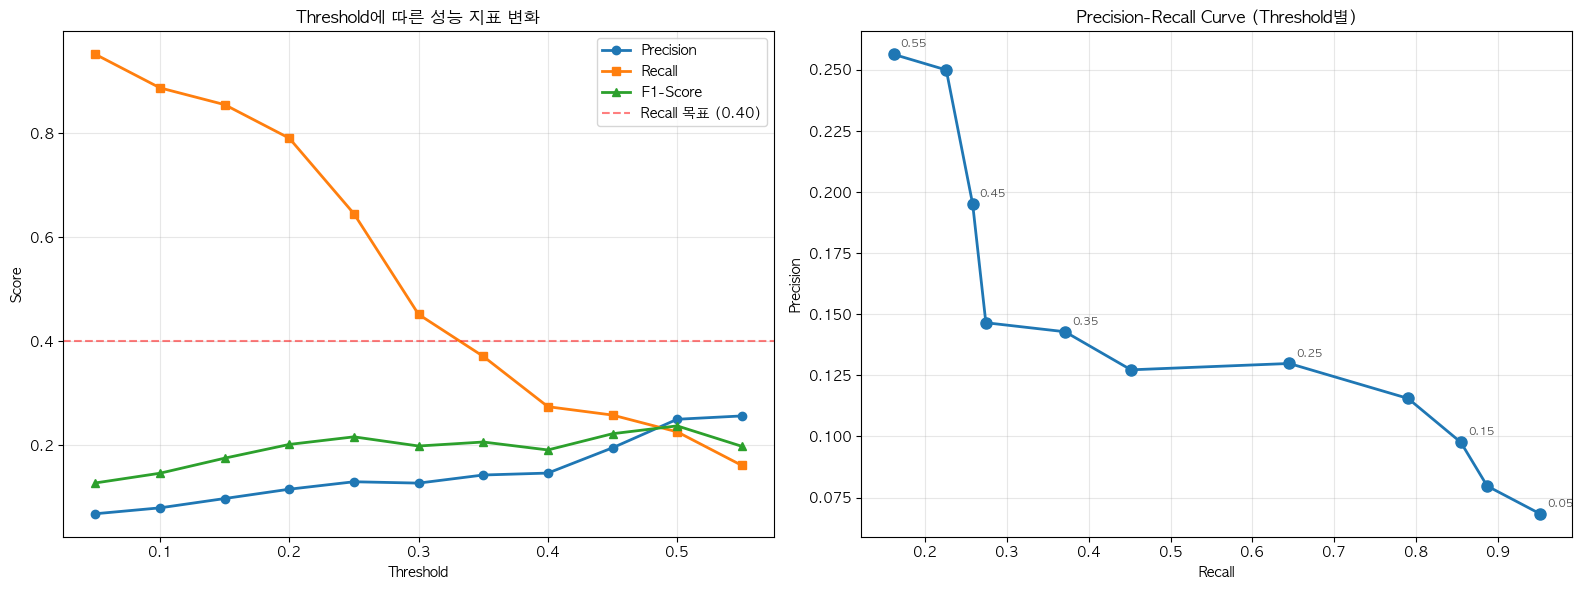

In [ ]:
# 8.9.16 Threshold별 성능 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Precision, Recall, F1-Score 추이
ax1 = axes[0]
ax1.plot(df_threshold['threshold'], df_threshold['precision'], 'o-', label='Precision', linewidth=2)
ax1.plot(df_threshold['threshold'], df_threshold['recall'], 's-', label='Recall', linewidth=2)
ax1.plot(df_threshold['threshold'], df_threshold['f1_score'], '^-', label='F1-Score', linewidth=2)
ax1.axhline(y=0.40, color='red', linestyle='--', alpha=0.5, label='Recall 목표 (0.40)')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Threshold에 따른 성능 지표 변화')
ax1.legend()
ax1.grid(alpha=0.3)

# Precision-Recall Curve
ax2 = axes[1]
ax2.plot(df_threshold['recall'], df_threshold['precision'], 'o-', linewidth=2, markersize=8)
for i, row in df_threshold.iterrows():
    if i % 2 == 0:  # 매 2번째만 표시
        ax2.annotate(f"{row['threshold']:.2f}", 
                    xy=(row['recall'], row['precision']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve (Threshold별)')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 최적 Threshold 적용 및 최종 평가

print("\n" + "=" * 80)
print("최적 Threshold 적용 및 최종 평가")
print("=" * 80)

# Recall 우선 Threshold 적용
optimal_threshold = best_thresh_recall['threshold']
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# 성능 평가
cm_optimal = confusion_matrix(y_test_enh, y_pred_optimal)
print(f"\n[최적 Threshold: {optimal_threshold:.2f}]")
print(f"  Precision: {best_thresh_recall['precision']:.4f}")
print(f"  Recall:    {best_thresh_recall['recall']:.4f}")
print(f"  F1-Score:  {best_thresh_recall['f1_score']:.4f}")

print(f"\n[Confusion Matrix]")
print(f"  TN={cm_optimal[0,0]:,}  FP={cm_optimal[0,1]:,}")
print(f"  FN={cm_optimal[1,0]:,}  TP={cm_optimal[1,1]:,}")

print(f"\n[Classification Report]")
print(classification_report(y_test_enh, y_pred_optimal, target_names=['정상', '유의 판매자']))


최적 Threshold 적용 및 최종 평가

[최적 Threshold: 0.25]
  Precision: 0.1299
  Recall:    0.6452
  F1-Score:  0.2162

[Confusion Matrix]
  TN=781  FP=268
  FN=22  TP=40

[Classification Report]
              precision    recall  f1-score   support

          정상       0.97      0.74      0.84      1049
      유의 판매자       0.13      0.65      0.22        62

    accuracy                           0.74      1111
   macro avg       0.55      0.69      0.53      1111
weighted avg       0.93      0.74      0.81      1111



---

## Step 8.9.18 상호작용 피처 제외 실험

**실험 목적**: 상호작용 피처 4개(delay_negative_interaction, processing_seller_delay_interaction, total_risk_score, avg_delay_rate)를 제외했을 때 성능 변화 확인


In [ ]:
# 8.9.18.1 상호작용 피처 제외 데이터셋 생성

print("=" * 80)
print("8.9.18.1 상호작용 피처 제외 데이터셋 생성")
print("=" * 80)

# 제외할 상호작용 피처 (prev_ 접두어 포함)
interaction_features_to_exclude = [
    'prev_delay_negative_interaction',
    'prev_processing_seller_delay_interaction',
    'prev_total_risk_score',
    'prev_avg_delay_rate'
]

# 제외 후 남은 피처 (25개 - 4개 = 21개)
features_without_interaction = [f for f in final_enhanced_feature_cols if f not in interaction_features_to_exclude]

print(f"\n[피처 개수]")
print(f"  - 전체 피처: {len(final_enhanced_feature_cols)}개")
print(f"  - 제외 피처: {len(interaction_features_to_exclude)}개")
print(f"  - 남은 피처: {len(features_without_interaction)}개")

print(f"\n[제외된 상호작용 피처]")
for feat in interaction_features_to_exclude:
    print(f"  - {feat}")

# 새로운 데이터셋 생성
X_train_no_interact = X_train_enh[features_without_interaction]
X_test_no_interact = X_test_enh[features_without_interaction]

print(f"\n[데이터셋 shape]")
print(f"  - Train: {X_train_no_interact.shape}")
print(f"  - Test:  {X_test_no_interact.shape}")


8.9.18.1 상호작용 피처 제외 데이터셋 생성

[피처 개수]
  - 전체 피처: 25개
  - 제외 피처: 4개
  - 남은 피처: 21개

[제외된 상호작용 피처]
  - prev_delay_negative_interaction
  - prev_processing_seller_delay_interaction
  - prev_total_risk_score
  - prev_avg_delay_rate

[데이터셋 shape]
  - Train: (4443, 21)
  - Test:  (1111, 21)


In [ ]:
# 8.9.18.2 RandomForest 학습 (상호작용 피처 제외)

print("\n" + "=" * 80)
print("8.9.18.2 RandomForest 학습 (21개 피처 - 상호작용 제외)")
print("=" * 80)

# RandomForest 모델 초기화 및 학습
model_rf_no_interact = RandomForestClassifier(
    class_weight='balanced',
    max_depth=10,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model_rf_no_interact.fit(X_train_no_interact, y_train_enh)

# 예측
y_pred_no_interact = model_rf_no_interact.predict(X_test_no_interact)
y_pred_proba_no_interact = model_rf_no_interact.predict_proba(X_test_no_interact)[:, 1]

# 성능 평가 (기본 threshold 0.5)
acc_no_interact = accuracy_score(y_test_enh, y_pred_no_interact)
prec_no_interact = precision_score(y_test_enh, y_pred_no_interact, zero_division=0)
rec_no_interact = recall_score(y_test_enh, y_pred_no_interact)
f1_no_interact = f1_score(y_test_enh, y_pred_no_interact, zero_division=0)
roc_auc_no_interact = roc_auc_score(y_test_enh, y_pred_proba_no_interact)
cm_no_interact = confusion_matrix(y_test_enh, y_pred_no_interact)

print(f"\n[RandomForest 성능 (상호작용 피처 제외, threshold=0.5)]")
print(f"  - Accuracy:  {acc_no_interact:.4f}")
print(f"  - Precision: {prec_no_interact:.4f}")
print(f"  - Recall:    {rec_no_interact:.4f}")
print(f"  - F1-Score:  {f1_no_interact:.4f}")
print(f"  - ROC-AUC:   {roc_auc_no_interact:.4f}")

print(f"\n[Confusion Matrix]")
print(f"  TN={cm_no_interact[0,0]:,}  FP={cm_no_interact[0,1]:,}")
print(f"  FN={cm_no_interact[1,0]:,}  TP={cm_no_interact[1,1]:,}")

print(f"\n[Classification Report]")
print(classification_report(y_test_enh, y_pred_no_interact, target_names=['정상', '유의 판매자']))



8.9.18.2 RandomForest 학습 (21개 피처 - 상호작용 제외)

[RandomForest 성능 (상호작용 피처 제외, threshold=0.5)]
  - Accuracy:  0.9208
  - Precision: 0.2679
  - Recall:    0.2419
  - F1-Score:  0.2542
  - ROC-AUC:   0.7524

[Confusion Matrix]
  TN=1,008  FP=41
  FN=47  TP=15

[Classification Report]
              precision    recall  f1-score   support

          정상       0.96      0.96      0.96      1049
      유의 판매자       0.27      0.24      0.25        62

    accuracy                           0.92      1111
   macro avg       0.61      0.60      0.61      1111
weighted avg       0.92      0.92      0.92      1111



In [ ]:
# 8.9.18.3 최적 Threshold 적용 (상호작용 피처 제외)

print("\n" + "=" * 80)
print("8.9.18.3 최적 Threshold 0.25 적용")
print("=" * 80)

# Threshold 0.25로 예측 (기존 모델과 동일한 기준)
y_pred_no_interact_025 = (y_pred_proba_no_interact >= 0.25).astype(int)

# 성능 평가
prec_no_interact_025 = precision_score(y_test_enh, y_pred_no_interact_025, zero_division=0)
rec_no_interact_025 = recall_score(y_test_enh, y_pred_no_interact_025)
f1_no_interact_025 = f1_score(y_test_enh, y_pred_no_interact_025, zero_division=0)
cm_no_interact_025 = confusion_matrix(y_test_enh, y_pred_no_interact_025)

print(f"\n[RandomForest 성능 (상호작용 피처 제외, threshold=0.25)]")
print(f"  - Precision: {prec_no_interact_025:.4f}")
print(f"  - Recall:    {rec_no_interact_025:.4f}")
print(f"  - F1-Score:  {f1_no_interact_025:.4f}")
print(f"  - ROC-AUC:   {roc_auc_no_interact:.4f}")

print(f"\n[Confusion Matrix]")
print(f"  TN={cm_no_interact_025[0,0]:,}  FP={cm_no_interact_025[0,1]:,}")
print(f"  FN={cm_no_interact_025[1,0]:,}  TP={cm_no_interact_025[1,1]:,}")

print(f"\n[Classification Report]")
print(classification_report(y_test_enh, y_pred_no_interact_025, target_names=['정상', '유의 판매자']))



8.9.18.3 최적 Threshold 0.25 적용

[RandomForest 성능 (상호작용 피처 제외, threshold=0.25)]
  - Precision: 0.1197
  - Recall:    0.5968
  - F1-Score:  0.1995
  - ROC-AUC:   0.7524

[Confusion Matrix]
  TN=777  FP=272
  FN=25  TP=37

[Classification Report]
              precision    recall  f1-score   support

          정상       0.97      0.74      0.84      1049
      유의 판매자       0.12      0.60      0.20        62

    accuracy                           0.73      1111
   macro avg       0.54      0.67      0.52      1111
weighted avg       0.92      0.73      0.80      1111



In [ ]:
test_indices = y_test_enh.index
prediction_df = df_final_enhanced.loc[test_indices, ['seller_id', 'year_month']].copy()
prediction_df['predicted'] = y_pred_no_interact_025
prediction_df['predict_proba'] = y_pred_proba_no_interact

# predicted=1만 필터링
risk_sellers = prediction_df[prediction_df['predicted'] == 1].copy()

# 위험사유 매핑 (간단하게)
risk_names = {
    'processing_delay': '처리지연율',
    'seller_delay': '출고지연율',
    'negative_review': '부정리뷰율',
    'critical_complaint': '심각한불만'
}

# 각 판매자의 위험사유 찾기
risk_reasons = []
for idx in risk_sellers.index:
    features = X_test_no_interact.loc[idx]
    
    # 위험 관련 피처만 가져오기
    risk_cols = [c for c in features.index 
                 if 'delay_rate' in c or 'negative_review_rate' in c or 'critical_complaint' in c]
    risk_vals = features[risk_cols].nlargest(2)
    
    # 상위 2개 위험사유 텍스트로 변환
    reasons = []
    for col_name, val in risk_vals.items():
        # 피처 이름에서 핵심 키워드 추출
        for key, name in risk_names.items():
            if key in col_name:
                reasons.append(f"{name}: {val*100:.0f}%")
                break
    
    risk_reasons.append(" | ".join(reasons) if reasons else "지연/리뷰 문제")

risk_sellers['주요_위험사유'] = risk_reasons

# predicted 컬럼 제거 (모두 1이므로)
risk_sellers = risk_sellers[['seller_id', 'year_month', 'predict_proba', '주요_위험사유']]

# 확률 높은 순으로 정렬
risk_sellers = risk_sellers.sort_values('predict_proba', ascending=False)

# CSV 저장
output_path = 'Olist_DataSet/risk_sellers_prediction.csv'
risk_sellers.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"저장: {output_path} ({len(risk_sellers):,}명의 위험 판매자)")
print(f"\n[위험 판매자 Top 10]")
print(risk_sellers.head(10).to_string(index=False))

저장: Olist_DataSet/risk_sellers_prediction.csv (309명의 위험 판매자)

[위험 판매자 Top 10]
                       seller_id year_month  predict_proba                            주요_위험사유
d93844a9c55ba7ce353388bcf849ea56    2017-05       0.834995    처리지연율 높음(100%) | 출고지연율 높음(100%)
f25e239052084705e17a982bc600ab2a    2018-03       0.822931    처리지연율 높음(100%) | 출고지연율 높음(100%)
ffdd9f82b9a447f6f8d4b91554cc7dd3    2018-06       0.808388    처리지연율 높음(100%) | 출고지연율 높음(100%)
fb89df7f89fd1b8f03fa2acca1ba7364    2018-07       0.767120    처리지연율 높음(100%) | 출고지연율 높음(100%)
f1ed6bd0a9b11b581f16c851c6a5a527    2017-09       0.738865    처리지연율 높음(100%) | 출고지연율 높음(100%)
df560393f3a51e74553ab94004ba5c87    2017-03       0.724152    처리지연율 높음(100%) | 출고지연율 높음(100%)
dc8798cbf453b7e0f98745e396cc5616    2017-05       0.718634    처리지연율 높음(100%) | 출고지연율 높음(100%)
dfc475d54e1b6dbeeb7d7d9bdaa63827    2018-06       0.714203    처리지연율 높음(100%) | 출고지연율 높음(100%)
dc8798cbf453b7e0f98745e396cc5616    2017-04       0.700284    처리지연율 높음(100%)